# 1. Introduction
---

## 1.1 Problem Statement

Property investment is one of large sector in Thailand.
Bangkok condo market is comming back after Covid-19, people are looking for affordable condominuim price.

Opportunities:
- Prices decreased due to covid situation.
- Many campaigns and discounts are being used to reinforce market demand.
- Condominium prices are likely to increase in 2023 due to higher construction costs and also residential market recovery.

Objectives:
- To conduct a model that could help investors to predict condominium prices.
- To be one of the tools that helps buyers find real condominium values.

# 2. Functions Preparation
---

## 2.1 Libraries Importation

In [2]:
# Import libraries

# General libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preprocessing and evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import metrics

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import xgboost

# Set pandas shown number format
pd.options.display.float_format = '{:.2f}'.format

## 2.2 In-notebook Functions Creation

In [463]:
# def split funciton
def split_feature(string):
    """Returns list from string that split by `|`"""
    try:
        return string.split("|")
    except:
        return None

In [466]:
def restructure_feature(keyword, keys_series, values_series):
    """ Return value in values_list of given keyword that matched keys_list"""
    result_list = []
    for i in range(len(keys_series)):
        try:
            result_list.append(list(values_series)[i][list(keys_series)[i].index(keyword)])
        except:
            result_list.append(None)
    return result_list

In [6]:
# Check data loss
def check_data_loss(df, new_df):
    """Return data loss information by comparing df with new_df"""
    len_df = df.shape[0]
    len_new_df = new_df.shape[0]
    print(f"Original data: {len_df}")
    print(f"Data after dropping: {len_new_df}")
    print(f"Row loss: {len_df - len_new_df}")
    print(f"%Loss: {round((len_df - len_new_df) / len_df * 100, 2)}")

In [471]:
# define function that returns closet distance to transportation facilities

def distance_str_to_float(string):
    """Covert string distance to float and covert to meter"""
    if len(string) > 0:
        trim_str = string.split('/')[0].strip()
        if trim_str[-2:] == 'km':
            return float(trim_str[:-3]) * 1000
        elif trim_str[-1] == 'm':
            return float(trim_str[:-2])
    else:
        return None

def get_distance_citytrain(category_list, distance_list):
    """Fuction use with dataframe .apply or .map
    Return: distance of closest city train in meter unit"""
    if (category_list != None):
        if ('marker marker-bts' in category_list) or ('marker marker-mrt' in category_list):
            convert_distance_list = []
            # Iterate all value in list to find city train distances
            for i in range(len(category_list)):
                if category_list[i] in ['marker marker-bts', 'marker marker-mrt']:
                    # Convert string to distance
                    convert_distance = distance_str_to_float(distance_list[i])
                    # Append all bts/mrt distances
                    if convert_distance != None:
                        convert_distance_list.append(convert_distance)
            # return closest distance
            convert_distance_list.sort()
            try:
                return convert_distance_list[0]
            except:
                return None
    return None

def get_distance_expressway(category_list, distance_list):
    """Fuction use with dataframe .apply or .map
    Return: distance of closest express way in meter unit"""
    if (category_list != None):
        if ('marker marker-expressway' in category_list):
            convert_distance_list = []
            # Iterate all value in list to find city train distances
            for i in range(len(category_list)):
                if category_list[i] in ['marker marker-expressway']:
                    # Convert string to distance
                    convert_distance = distance_str_to_float(distance_list[i])
                    # Append all bts/mrt distances
                    if convert_distance != None:
                        convert_distance_list.append(convert_distance)
            # return closest distance
            convert_distance_list.sort()
            try:
                return convert_distance_list[0]
            except:
                return None
    return None

In [32]:
def missing_values_df(df):
    """Return dataframe of missing values and its percentage comparing with total length of dataframe"""
    missing_df = pd.DataFrame({'n_missing': df.isnull().sum().sort_values(ascending=False)})
    missing_df['pct_missing'] = round(missing_df['n_missing'] / len(df) * 100, 2)
    return missing_df[missing_df['n_missing'] > 0]

In [37]:
# create function to return model metrics

def reg_metrics(trained_model, X_train, X_test, y_train, y_test, 
                cross_val=True, log_y=False):
    """Return evaluation metrices of regression problems:
    """
    # Predict y
    y_train_preds = trained_model.predict(X_train)
    y_test_preds = trained_model.predict(X_test)
    
    # Compute R^2
    train_r2 = metrics.r2_score(y_train, y_train_preds)
    test_r2 = metrics.r2_score(y_test, y_test_preds)
    
    
    # Turn of cross validation scores if cross_val == Fasle
    if cross_val == True:
        cross_train = cross_val_score(trained_model, X_train, y_train)
        cross_train_mean = cross_val_score(trained_model, X_train, y_train).mean()
    else:
        cross_train = None
        cross_train_mean = None
    
    
    # If log is True -> Turn y to exp(y) to return MSE as the same units
    if log_y == True:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_train_preds = np.exp(y_train_preds)
        y_test_preds = np.exp(y_test_preds)
    else:
        pass
    
    # Compute MSE
    train_mae = metrics.mean_absolute_error(y_train, y_train_preds)
    train_rmse = metrics.mean_squared_error(y_train, y_train_preds, squared=False)
    test_mae = metrics.mean_absolute_error(y_test, y_test_preds)
    test_rmse = metrics.mean_squared_error(y_test, y_test_preds, squared=False)

        
    print(f"""-----------Train Data-----------
MAE: {train_mae}
MSE: {train_rmse**2}
RMSE: {train_rmse}
R2: {train_r2}
Cross Validation: {cross_train}
Cross Validation Mean: {cross_train_mean}
--------------------------------""")
    print(f"""-----------Test Data-----------
MAE: {test_mae}
MSE: {test_rmse**2}
RMSE: {test_rmse}
R2: {test_r2}
--------------------------------""")

In [38]:
def plot_ytrue_ypred(trained_model, X_train, X_test, y_train, y_test, mode=None):
    """Make scatter plots of y_true vs y_pred separating train and test set by subplots"""
    
    # Make prediction
    train_preds = trained_model.predict(X_train)
    test_preds = trained_model.predict(X_test)
    
    # Exponential data if mode is 'exp'
    if mode == 'exp':
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        train_preds = np.exp(train_preds)
        test_preds = np.exp(test_preds)
        
    # Set axis
    train_min_val = min(min(y_train), min(train_preds)) * 0.9
    train_max_val = max(max(y_train), max(train_preds)) * 1.1    
    test_min_val = min(min(y_test), min(test_preds)) * 0.9
    test_max_val = max(max(y_test), max(test_preds)) * 1.1

    # Set plot
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Prediction vs. Actual Values', size=20)

    # Train chart
    axs[0].scatter(y_train, train_preds, color='#4E64A6')
    axs[0].axline([train_min_val, train_min_val], [train_max_val, train_max_val], color='black')
    axs[0].set_title('Training', size=15)
    axs[0].set_xlabel('Actual Values', size=12)
    axs[0].set_ylabel('Prediction', size=12)

    # Test chart
    axs[1].scatter(y_test, test_preds, color='#747F7F') 
    axs[1].axline([test_min_val, test_min_val], [test_max_val, test_max_val], color='black')
    axs[1].set_title('Testing', size=15)
    axs[1].set_xlabel('Actual Values', size=12)
    axs[1].set_ylabel('Prediction', size=12)

In [85]:
def plot_residual(trained_model, X_train, X_test, y_train, y_test):
    """Make residual plots by subplots of train and test dataset"""
    
    # Make prediction
    train_preds = trained_model.predict(X_train)
    test_preds = trained_model.predict(X_test)
    
    # Calculate residual
    train_res = train_preds - y_train
    test_res = test_preds - y_test

    # Set plot
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Residuals vs. Actual Values', size=20)

    # Train chart
    sns.residplot(x=y_train, y=train_res, ax=axs[0], color='#4E64A6')
    axs[0].set_title('Training', size=15)
    axs[0].set_xlabel('Actual Values', size=12)
    axs[0].set_ylabel('Residual', size=12)

    # Test chart
    sns.residplot(x=y_test, y=test_res, ax=axs[1], color='#747F7F') 
    axs[1].set_title('Testing', size=15)
    axs[1].set_xlabel('Actual Values', size=12)
    axs[1].set_ylabel('Residual', size=12)

In [350]:
def make_prediction(final_model, test_data):
    """Print predicted value from given train model and dataset as dict"""
    features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
    ]
    df_test = pd.DataFrame(test_data)
    
    # Get dummy features by one hot encoder
    df_dummy_district = pd.DataFrame(oh.transform(df_test[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())
    
    X_test = df_test[features].merge(df_dummy_district, left_index=True, right_index=True)
    
    predict_value = final_model.predict(X_test)
    
    print("Expected value is:", predict_value[0], "THB")

# 3. Data Preparation
---

## 3.1 Data Consolidation

In [453]:
raw_df = pd.DataFrame()

# Set relative path for raw data folder
relative_path = ".\selenium\scrape_data"

# Get file names in folder as a list
folder_names = os.listdir(relative_path)

# Iterate raw csv files in folder
for folder_name in folder_names:
    file_names = os.listdir(f"{relative_path}\\{folder_name}")
    for file_name in file_names:
        try: 
            temp_df = pd.read_csv(f"{relative_path}\\{folder_name}\\{file_name}")
            raw_df = pd.concat([raw_df, temp_df])
        except:
            # Print error file name
            print(file_name)

## 3.2 Data Cleansing

### 3.2.1 Duplication Removal

In [454]:
# Check data shape
# There are 32,686 rows and 21 features from raw datas
raw_df.shape

(32686, 21)

In [455]:
# Check duplicate data
# Dataset contains _ duplicate rows, we can drop it.
raw_df.duplicated().sum()

3595

In [456]:
# Drop duplicate rows and check result
raw_df.drop_duplicates(inplace=True)
raw_df.shape

(29091, 21)

In [457]:
# Drop rows that contain null value in 'amennity_values' column 
# due to old format of website that returned a lot of missing values to our dataframe.
raw_df.dropna(subset = ['amenity_values'], inplace=True)
raw_df.shape

(22915, 21)

In [458]:
# Drop unused columns
raw_df.drop(columns=['address', 'description', 'detail'], inplace=True)

In [459]:
# Reset index after dropping duplicate rows
raw_df = raw_df.reset_index(drop=True)

In [460]:
# Check index head
raw_df.head(2)

dev  district  sale_price  rent_price  \
0  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
1  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   

              internal_feature_keys internal_feature_values  \
0  Bedrooms|Bathrooms|Internal area                  1|1|30   
1            Bedrooms|Internal area                    1|28   

      external_feature_keys exteranal_feature_values  \
0  Floors|Towers|Year built                25|1|2017   
1  Floors|Towers|Year built                25|1|2017   

                                        amenity_keys  \
0  Elevator|Parking|24-hours Security|CCTV|Swimmi...   
1  Elevator|Parking|24-hours Security|CCTV|Swimmi...   

                                      amenity_values  \
0  True|True|True|True|True|False|True|True|True|...   
1  True|True|True|True|True|False|True|True|True|...   

                                       neighbor_cats  \
0  marker marker-expressway|marker marker-bts|mar...   
1  marker marker-expressway|marker marker-bts|mar...   

                                      neighbor_names  \
0  Bang Khun Thian Toll Plaza-Outbound 1|Wutthaka...   
1  Bang Khun Thian Toll Plaza-Outbound 1|Wutthaka...   

                                  neighbor_distances asking_price  \
0  6.2 km / 36 minutes by car|6.6 km / 10 minutes...       57,995   
1  6.2 km / 36 minutes by car|6.6 km / 10 minutes...       57,995   

   asking_price_change_quater asking_price_change_year  gross_rental_yield  \
0                        0.00                     1.11                5.50   
1                        0.00                     1.11                5.50   

  rental_price_change_year  
0                    11.30  
1                    11.30

In [461]:
# Check index tail
raw_df.tail(2)

dev  district  sale_price  rent_price  \
22913  Lumpini Place Narathiwas 24  Yan Nawa  6700000.00    23000.00   
22914          Fuse Chan - Sathorn  Yan Nawa  3200000.00         NaN   

                  internal_feature_keys internal_feature_values  \
22913  Bedrooms|Bathrooms|Internal area                  2|2|63   
22914  Bedrooms|Bathrooms|Internal area                1|1|34.5   

                       external_feature_keys exteranal_feature_values  \
22913  Floors|Towers|Project Area|Year built        9|2|3,300 m2|2003   
22914  Floors|Towers|Project Area|Year built      31|3|11,868 m2|2015   

                                            amenity_keys  \
22913  Elevator|Parking|24-hours Security|CCTV|Swimmi...   
22914  Elevator|Parking|24-hours Security|CCTV|Swimmi...   

                                          amenity_values  \
22913  True|True|True|True|True|False|True|False|Fals...   
22914  True|True|True|True|True|False|True|True|False...   

                                           neighbor_cats  \
22913  marker marker-expressway|marker marker-express...   
22914  marker marker-expressway|marker marker-express...   

                                          neighbor_names  \
22913  Sathu Pradit 2 Toll Plaza|Sathu Pradit 3 Toll ...   
22914  Chan Toll Plaza|Sathon Toll Plaza|Sathu Pradit...   

                                      neighbor_distances asking_price  \
22913  1.1 km / 4 minutes by car|1.1 km / 4 minutes b...       79,486   
22914  1 km / 6 minutes by car|1.7 km / 10 minutes by...       92,308   

       asking_price_change_quater asking_price_change_year  \
22913                        0.00                     4.55   
22914                       -2.98                    -2.91   

       gross_rental_yield rental_price_change_year  
22913                5.50                   -32.22  
22914                5.50                     5.75

### 3.2.2 Features Preparation
From scraping process, some features were collected as list of features due to uncertainty of the features occurrence that make .csv unable to store it in one column. 
<br>In-order-that, a list of features were joined by `|` to be a single string.

For example, column `internal_feature_keys` and `internal_feature_values` contain information of `number of bedrooms`, `number of bathrooms`, and `internal area` together as
<br>`bedrooms|bathrooms|internal area`.

**Hence, this section is to split the joined features to be ready for analyzing.**

In [462]:
raw_df.head(2)

dev  district  sale_price  rent_price  \
0  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
1  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   

              internal_feature_keys internal_feature_values  \
0  Bedrooms|Bathrooms|Internal area                  1|1|30   
1            Bedrooms|Internal area                    1|28   

      external_feature_keys exteranal_feature_values  \
0  Floors|Towers|Year built                25|1|2017   
1  Floors|Towers|Year built                25|1|2017   

                                        amenity_keys  \
0  Elevator|Parking|24-hours Security|CCTV|Swimmi...   
1  Elevator|Parking|24-hours Security|CCTV|Swimmi...   

                                      amenity_values  \
0  True|True|True|True|True|False|True|True|True|...   
1  True|True|True|True|True|False|True|True|True|...   

                                       neighbor_cats  \
0  marker marker-expressway|marker marker-bts|mar...   
1  marker marker-expressway|marker marker-bts|mar...   

                                      neighbor_names  \
0  Bang Khun Thian Toll Plaza-Outbound 1|Wutthaka...   
1  Bang Khun Thian Toll Plaza-Outbound 1|Wutthaka...   

                                  neighbor_distances asking_price  \
0  6.2 km / 36 minutes by car|6.6 km / 10 minutes...       57,995   
1  6.2 km / 36 minutes by car|6.6 km / 10 minutes...       57,995   

   asking_price_change_quater asking_price_change_year  gross_rental_yield  \
0                        0.00                     1.11                5.50   
1                        0.00                     1.11                5.50   

  rental_price_change_year  
0                    11.30  
1                    11.30

In [464]:
# List of joined feature column names
joined_features = ['internal_feature_keys', 'internal_feature_values', 'external_feature_keys', 'exteranal_feature_values',
                  'amenity_keys', 'amenity_values', 'neighbor_cats', 'neighbor_names', 'neighbor_distances']

# Iterate column names to create list
for feature in joined_features:
    raw_df[feature] = raw_df[feature].apply(split_feature)

In [465]:
# Check result
raw_df.head(2)

dev  district  sale_price  rent_price  \
0  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
1  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   

                  internal_feature_keys internal_feature_values  \
0  [Bedrooms, Bathrooms, Internal area]              [1, 1, 30]   
1             [Bedrooms, Internal area]                 [1, 28]   

          external_feature_keys exteranal_feature_values  \
0  [Floors, Towers, Year built]            [25, 1, 2017]   
1  [Floors, Towers, Year built]            [25, 1, 2017]   

                                        amenity_keys  \
0  [Elevator, Parking, 24-hours Security, CCTV, S...   
1  [Elevator, Parking, 24-hours Security, CCTV, S...   

                                      amenity_values  \
0  [True, True, True, True, True, False, True, Tr...   
1  [True, True, True, True, True, False, True, Tr...   

                                       neighbor_cats  \
0  [marker marker-expressway, marker marker-bts, ...   
1  [marker marker-expressway, marker marker-bts, ...   

                                      neighbor_names  \
0  [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
1  [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   

                                  neighbor_distances asking_price  \
0  [6.2 km / 36 minutes by car, 6.6 km / 10 minut...       57,995   
1  [6.2 km / 36 minutes by car, 6.6 km / 10 minut...       57,995   

   asking_price_change_quater asking_price_change_year  gross_rental_yield  \
0                        0.00                     1.11                5.50   
1                        0.00                     1.11                5.50   

  rental_price_change_year  
0                    11.30  
1                    11.30

In [467]:
# Restructure list to columns
# Internal features
raw_df['bedrooms'] = restructure_feature('Bedrooms', raw_df['internal_feature_keys'], raw_df['internal_feature_values'])
raw_df['bathrooms'] = restructure_feature('Bathrooms', raw_df['internal_feature_keys'], raw_df['internal_feature_values'])
raw_df['internal_area'] = restructure_feature('Internal area', raw_df['internal_feature_keys'], raw_df['internal_feature_values'])

In [468]:
# Restructure list to columns
# External features
raw_df['floors'] = restructure_feature('Floors', raw_df['external_feature_keys'], raw_df['exteranal_feature_values'])
raw_df['towers'] = restructure_feature('Towers', raw_df['external_feature_keys'], raw_df['exteranal_feature_values'])
raw_df['project_area'] = restructure_feature('Project Area', raw_df['external_feature_keys'], raw_df['exteranal_feature_values'])
raw_df['year_built'] = restructure_feature('Year built', raw_df['external_feature_keys'], raw_df['exteranal_feature_values'])

In [469]:
# Restructure list to columns
# Amenities
raw_df['has_elevator'] = restructure_feature('Elevator', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_parking'] = restructure_feature('Parking', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_security'] = restructure_feature('24-hours Security', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_cctv'] = restructure_feature('CCTV', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_pool'] = restructure_feature('Swimming Pool', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_sauna'] = restructure_feature('Sauna', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_gym'] = restructure_feature('Gym', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_garden_bbq'] = restructure_feature('Garden / BBQ', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_playground'] = restructure_feature("Playground / Kid's Area", raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_shop_on_premise'] = restructure_feature('Shop on Premise', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_restaurant_on_premise'] = restructure_feature('Restaurant on Premise', raw_df['amenity_keys'], raw_df['amenity_values'])
raw_df['has_wifi'] = restructure_feature('Wi-Fi', raw_df['amenity_keys'], raw_df['amenity_values'])

In [470]:
# Restructure list to columns
# neighborhood
raw_df[['neighbor_cats', 'neighbor_names', 'neighbor_distances']]

neighbor_cats  \
0      [marker marker-expressway, marker marker-bts, ...   
1      [marker marker-expressway, marker marker-bts, ...   
2      [marker marker-expressway, marker marker-bts, ...   
3      [marker marker-expressway, marker marker-bts, ...   
4      [marker marker-expressway, marker marker-bts, ...   
...                                                  ...   
22910  [marker marker-expressway, marker marker-expre...   
22911  [marker marker-expressway, marker marker-expre...   
22912  [marker marker-expressway, marker marker-expre...   
22913  [marker marker-expressway, marker marker-expre...   
22914  [marker marker-expressway, marker marker-expre...   

                                          neighbor_names  \
0      [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
1      [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
2      [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
3      [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
4      [Bang Khun Thian Toll Plaza-Outbound 1, Wuttha...   
...                                                  ...   
22910  [Rama 4-2 Toll Plaza, Rama 4-1 Toll Plaza, Khl...   
22911  [Rama 3 Toll Plaza, Sathu Pradit 2 Toll Plaza,...   
22912  [River Side Toll Plaza, Rama 4-2 Toll Plaza, R...   
22913  [Sathu Pradit 2 Toll Plaza, Sathu Pradit 3 Tol...   
22914  [Chan Toll Plaza, Sathon Toll Plaza, Sathu Pra...   

                                      neighbor_distances  
0      [6.2 km / 36 minutes by car, 6.6 km / 10 minut...  
1      [6.2 km / 36 minutes by car, 6.6 km / 10 minut...  
2      [6.2 km / 36 minutes by car, 6.6 km / 10 minut...  
3      [6.2 km / 36 minutes by car, 6.6 km / 10 minut...  
4      [6.2 km / 36 minutes by car, 6.6 km / 10 minut...  
...                                                  ...  
22910  [1.1 km / 5 minutes by car, 1.1 km / 4 minutes...  
22911  [680 m / 8 minutes by foot, 1.8 km / 4 minutes...  
22912  [450 m / 5 minutes by foot, 2 km / 9 minutes b...  
22913  [1.1 km / 4 minutes by car, 1.1 km / 4 minutes...  
22914  [1 km / 6 minutes by car, 1.7 km / 10 minutes ...  

[22915 rows x 3 columns]

**Neighborhood features have to be done more additional steps to split list to be columns.** 
<br>These features are about the top 6 nerest transportation facilities, which including city train(BTS and MRT), express way.
These features were captured by iteration of algorithm that made a length of list for each row 

Challenges:
1. Differece in number of value in list: 0 to 6
2. Differece in order of value in categorical list
3. Difference in type of facility
4. Difference in unit of measurement: meters, kilometers

**To simplify these features' situation, features will be cosidered as two types:**
1. Nearest distance between condominium and tranportation facilities
    - City train
    - Express way
2. Boolean features wheater condominium is closer than 1 km. to transportation facilities
    - City train
    - Express way

In [472]:
# Create transport facility distance columns
raw_df['city_train_distance'] = raw_df[['neighbor_cats', 'neighbor_distances']].apply(lambda x: get_distance_citytrain(x[0], x[1]), axis=1)
raw_df['express_way_distance'] = raw_df[['neighbor_cats', 'neighbor_distances']].apply(lambda x: get_distance_expressway(x[0], x[1]), axis=1)

# Create boolean columns if distance <= 1 km.
raw_df['close_city_train'] = raw_df['city_train_distance'].apply(lambda x: int(x <= 1000) if x != None else 0)
raw_df['close_express_way'] = raw_df['express_way_distance'].apply(lambda x: int(x <= 1000) if x != None else 0)

In [473]:
# Drop unused columns
raw_df.drop(columns=joined_features, inplace=True)

In [474]:
raw_df.head()

dev  district  sale_price  rent_price  \
0  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
1  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
2  J Condo Sathorn - Kallaprapruk  Bang Bon  1390000.00         NaN   
3  J Condo Sathorn - Kallaprapruk  Bang Bon  1790000.00         NaN   
4  J Condo Sathorn - Kallaprapruk  Bang Bon  1290000.00         NaN   

  asking_price  asking_price_change_quater asking_price_change_year  \
0       57,995                        0.00                     1.11   
1       57,995                        0.00                     1.11   
2       57,995                        0.00                     1.11   
3       57,995                        0.00                     1.11   
4       57,995                        0.00                     1.11   

   gross_rental_yield rental_price_change_year bedrooms  ... has_gym  \
0                5.50                    11.30        1  ...    True   
1                5.50                    11.30        1  ...    True   
2                5.50                    11.30        1  ...    True   
3                5.50                    11.30        1  ...    True   
4                5.50                    11.30        1  ...    True   

  has_garden_bbq has_playground has_shop_on_premise has_restaurant_on_premise  \
0           True           True               False                     False   
1           True           True               False                     False   
2           True           True               False                     False   
3           True           True               False                     False   
4           True           True               False                     False   

  has_wifi city_train_distance express_way_distance close_city_train  \
0    False             6600.00              6200.00                0   
1    False             6600.00              6200.00                0   
2    False             6600.00              6200.00                0   
3    False             6600.00              6200.00                0   
4    False             6600.00              6200.00                0   

  close_express_way  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 32 columns]

### 3.2.3 Missing Values and Data Types Check

In [476]:
# Check missing values
missing_values_df(raw_df)

n_missing  pct_missing
rent_price                      19820        86.49
project_area                    10359        45.21
bathrooms                        2496        10.89
year_built                       2077         9.06
has_restaurant_on_premise        1805         7.88
has_playground                   1558         6.80
has_shop_on_premise              1248         5.45
has_wifi                         1128         4.92
has_sauna                        1124         4.91
bedrooms                          847         3.70
rental_price_change_year          592         2.58
gross_rental_yield                592         2.58
asking_price                      592         2.58
asking_price_change_quater        592         2.58
asking_price_change_year          592         2.58
express_way_distance              559         2.44
has_garden_bbq                    434         1.89
city_train_distance               409         1.78
floors                            322         1.41
has_cctv                          310         1.35
has_gym                           302         1.32
has_elevator                      290         1.27
internal_area                     251         1.10
has_pool                           41         0.18
has_security                       20         0.09
has_parking                         6         0.03
towers                              1         0.00

**According to missing value table, missing values can be separated to 4 groups by number of missing and approach to fix them.**
1. **High percentage of missig data:**
    - Approch: Drop whole columns
    - `rent_price` : 86.46% missing
    - `project_area` : 42.49% missing
2. **Boolean columns (all amenity features):**
    - Approch: Treat missing data as 0 since absences of objects that unable to scrape could imply that condominiums do not have these fuctions.
3. **Columns that missing percentage less than or equal to 15%:**
    - `year_built` which has 15% of missing also considered
    - 2 approaches could be applied:
        - Drop missing rows
        - Impute median values
4.**Columns that do not need to fix:** Sice they are additional detail of codominiums.
    - `dev`
    - `address`
    - `detail`
    - `description`

In [477]:
# 1. Drop columns
raw_df.drop(columns=['rent_price', 'project_area'], inplace=True)

In [478]:
# 2. Fill null with zero for boolean features
amenity_columns = raw_df.columns[raw_df.columns.str.contains('has')]
raw_df[amenity_columns] = raw_df[amenity_columns].fillna(value=0)

In [479]:
# 3. Columns that missing percentage less than or equal to 15%

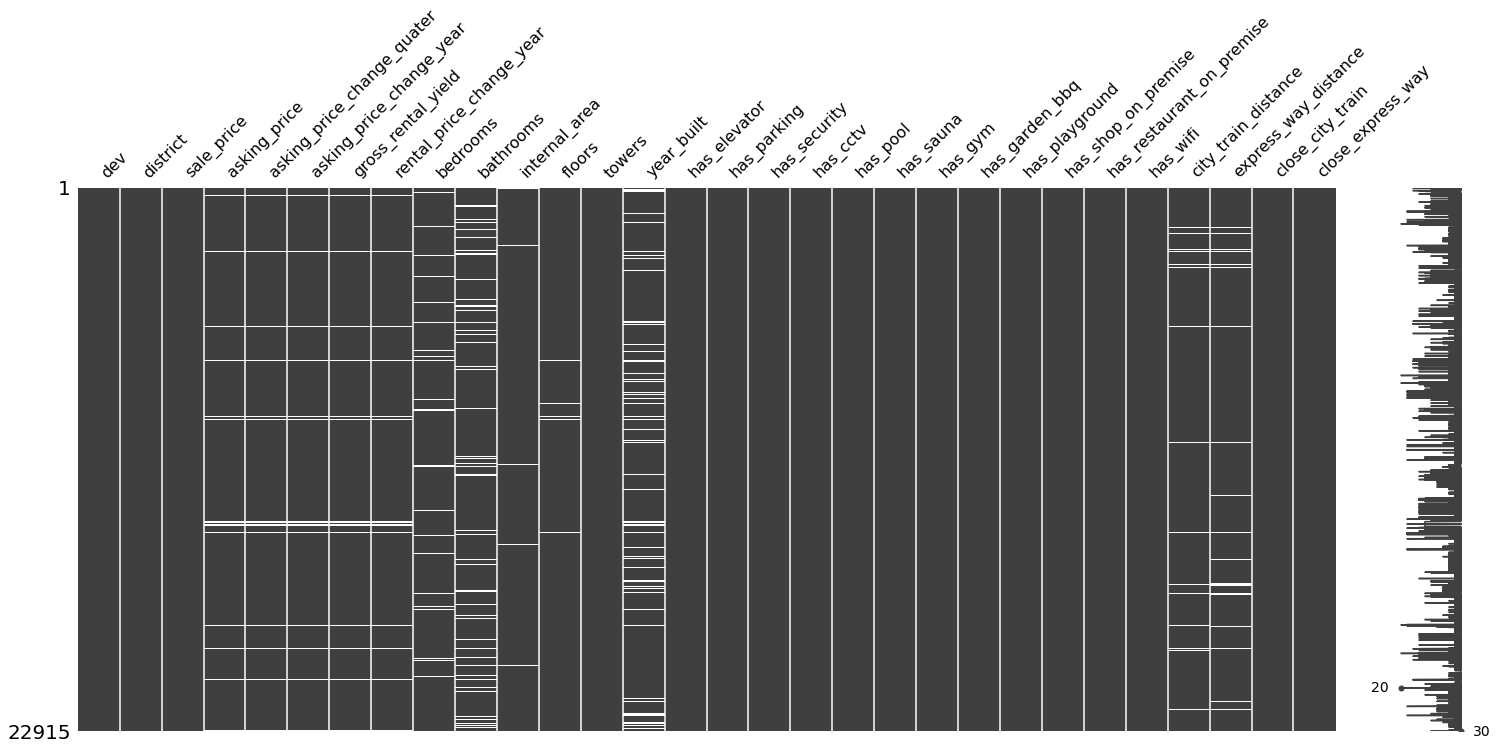

In [480]:
# Check missing values by missingno library to see patern and effect on missing data
msno.matrix(raw_df);

**From missingno matrix**, data are likely to be missing on the different rows, which could imply that if we drop row that contain null, 
<br>data will be missing more than 10% based on maxmimum percentage of missing values. 

In [481]:
# Check if we drop rows that contain missing value
len_df = raw_df.shape[0]
len_drop_df = raw_df.drop(columns=['dev']).dropna().shape[0]
print(f"Original data: {len_df}")
print(f"Data after dropping null: {len_drop_df}")
print(f"Row loss: {len_df - len_drop_df}")
print(f"%Loss: {round((len_df - len_drop_df) / len_df * 100, 2)}")

Original data: 22915
Data after dropping null: 17243
Row loss: 5672
%Loss: 24.75


**If we drop null values**, data will be decreased 5,672 rows, which are 24.75% of original rows, and will be 17,243 rows totally.
<br>17,243 data are still accepctable for regression problem but we can also try to impute data.
<br> We will pause fixing missing values for a moment and cotinue again when we're doing model after train test spliting to avoid data leakage.


In [482]:
# Check missing values
missing_values_df(raw_df)

n_missing  pct_missing
bathrooms                        2496        10.89
year_built                       2077         9.06
bedrooms                          847         3.70
asking_price                      592         2.58
asking_price_change_quater        592         2.58
asking_price_change_year          592         2.58
gross_rental_yield                592         2.58
rental_price_change_year          592         2.58
express_way_distance              559         2.44
city_train_distance               409         1.78
floors                            322         1.41
internal_area                     251         1.10
towers                              1         0.00

### 3.2.4 Data Type Check
Data were scraped as text without any transforming before saving to .csv, therefore we need to turn numeric features to be appropriate form.

In [483]:
raw_df.dtypes

dev                            object
district                       object
sale_price                    float64
asking_price                   object
asking_price_change_quater    float64
asking_price_change_year       object
gross_rental_yield            float64
rental_price_change_year       object
bedrooms                       object
bathrooms                      object
internal_area                  object
floors                         object
towers                         object
year_built                     object
has_elevator                   object
has_parking                    object
has_security                   object
has_cctv                       object
has_pool                       object
has_sauna                      object
has_gym                        object
has_garden_bbq                 object
has_playground                 object
has_shop_on_premise            object
has_restaurant_on_premise      object
has_wifi                       object
city_train_d

#### 3.2.4.1 Type Casting

##### **`asking_price`**
---

In [484]:
# Cast 'asking_price' to be float
# 'asking_price' has ',' in each value, we need to remove it before casting
raw_df['asking_price']

0         57,995
1         57,995
2         57,995
3         57,995
4         57,995
          ...   
22910    142,521
22911    126,211
22912    164,122
22913     79,486
22914     92,308
Name: asking_price, Length: 22915, dtype: object

In [485]:
# 'asking_price'
# Remove ','
raw_df['asking_price'] = raw_df['asking_price'].str.replace(',', '')

# Cast to float
raw_df['asking_price'] = raw_df['asking_price'].astype(float)

##### **`asking_price_change_year`**
---

In [486]:
# Cast 'asking_price_change_year' to be float
# 'asking_price_change_year' has '–' that represent of null value, we need to remove it.
raw_df['asking_price_change_year'][raw_df['asking_price_change_year'] == '–'][:5]

4299    –
4350    –
4351    –
4361    –
4368    –
Name: asking_price_change_year, dtype: object

In [487]:
# 'asking_price_change_year'
# Remove '–'
raw_df['asking_price_change_year'] = raw_df['asking_price_change_year'].replace('–', None)

# Cast to float
raw_df['asking_price_change_year'] = raw_df['asking_price_change_year'].astype(float)

##### **`rental_price_change_year`**
---

In [488]:
# Cast 'rental_price_change_year' to be float
# 'rental_price_change_year' has '–' that represent of null value, we need to remove it.
raw_df['rental_price_change_year'][raw_df['rental_price_change_year'] == '–'][:5]

28     –
114    –
135    –
136    –
137    –
Name: rental_price_change_year, dtype: object

In [489]:
# 'rental_price_change_year'
# Remove '–'
raw_df['rental_price_change_year'] = raw_df['rental_price_change_year'].replace('–', None)

# Cast to float
raw_df['rental_price_change_year'] = raw_df['rental_price_change_year'].astype(float)

##### **`internal_area`**
---
Problem: After trying to cast `internal_area` as float, an error raised up that ',' was found in the feature.
<br>So, we need to explore more about the feature whether it was a mistake by scaping process or a mistake from the website itself.

In [490]:
# Find values of 'internal_area' that contain ','
raw_df[['dev', 'sale_price', 'internal_area']][raw_df['internal_area'].str.find(',') > 0]

dev   sale_price internal_area
1987         Four Seasons Private Residences 475000000.00         1,050
2214         Four Seasons Private Residences 453933000.00         1,008
3376                            The Tree RIO   6190000.00     6,190,000
3781                    Commonwealth Pinklao  56990000.00       1,268.2
3819                    Bangkok River Marina 200000000.00         1,000
8195              Emerald Residence Ratchada   2750000.00        10,000
8409                      Belle Grand Rama 9  11700535.00        36,049
9061                 Condolette Midst Rama 9   4797000.00         2,940
10445               Siamese Exclusive Queens  13401574.00        44,814
11310                  The ESSE Sukhumvit 36  20302257.00        61,588
12365                           Baan Siri 31  12597426.00        11,746
12690                              Rin House   3953437.00        16,650
14063  Supalai Park Ratchaphruek - Phetkasem   1930000.00     1,000,000
18545                        Sathorn Gardens  30000000.00         2,000
18559               The Sukhothai Residences 580000000.00      1,182.69
18778               The Sukhothai Residences 580000000.00      1,182.69
18832               The Sukhothai Residences 580000000.00         1,182
20972                 Plum Condo Ladprao 101   1200000.00     1,000,000
21455                              Rin House   3953437.00        16,650
21954               Eight Thonglor Residence 360000000.00         1,000

**From the result above**, many rows incorrectly returned `internal_area`, which should be returned in square meter unit of room size.

**The possible reasons are:**
1. Incorrectly scraping problem
2. Incorrect input from the website

**Conclusion:** After revisiting the website, it was found that these observations were reported as overall internal area but unable to find the correct internal area of each room because of varity numbers of internal infrastructures. Therefore, **they will be replaced as null and be imputed in the future process.**

In [491]:
# Get incorrect values' indexes
selective_index = raw_df[['dev', 'sale_price', 'internal_area']][raw_df['internal_area'].str.find(',') > 0].index

# Replace 'internal_area' by None
raw_df.loc[selective_index, 'internal_area'] = None

# Check result
raw_df.loc[selective_index, ['dev', 'sale_price', 'internal_area']]

dev   sale_price internal_area
1987         Four Seasons Private Residences 475000000.00          None
2214         Four Seasons Private Residences 453933000.00          None
3376                            The Tree RIO   6190000.00          None
3781                    Commonwealth Pinklao  56990000.00          None
3819                    Bangkok River Marina 200000000.00          None
8195              Emerald Residence Ratchada   2750000.00          None
8409                      Belle Grand Rama 9  11700535.00          None
9061                 Condolette Midst Rama 9   4797000.00          None
10445               Siamese Exclusive Queens  13401574.00          None
11310                  The ESSE Sukhumvit 36  20302257.00          None
12365                           Baan Siri 31  12597426.00          None
12690                              Rin House   3953437.00          None
14063  Supalai Park Ratchaphruek - Phetkasem   1930000.00          None
18545                        Sathorn Gardens  30000000.00          None
18559               The Sukhothai Residences 580000000.00          None
18778               The Sukhothai Residences 580000000.00          None
18832               The Sukhothai Residences 580000000.00          None
20972                 Plum Condo Ladprao 101   1200000.00          None
21455                              Rin House   3953437.00          None
21954               Eight Thonglor Residence 360000000.00          None

In [492]:
# Now we can cast it as float
raw_df['internal_area'] = raw_df['internal_area'].astype(float)

##### **`bedrooms`**
---
`bedrooms` feature has one obstacle that make this feature unable to be casted as float, which is 'Studio' so we can replace it as 0 due to it as one room with all functions.

We also see some obviouse values in this feature, which bedrooms that too large number, so we need to explore it further.

In [493]:
raw_df['bedrooms'].unique()

array(['1', None, '3', '2', '5', '4', '11', 'Studio', '8', '6', '7', '9',
       '27'], dtype=object)

In [494]:
# Replace 'Studio' with zero
raw_df['bedrooms'] = raw_df['bedrooms'].replace('Studio', '0')

# Cast as float
raw_df['bedrooms'] = raw_df['bedrooms'].astype(float)

In [500]:
raw_df[raw_df['bedrooms'] >= 5][['dev', 'sale_price', 'bedrooms']].sort_values(by='sale_price')[:10]

dev  sale_price  bedrooms
11895  D Condo Onnut - Suvarnabhumi  1300000.00     11.00
8357             JW CONDO @DONMUANG  1690000.00      9.00
482    Bangkok Horizon Ramkhamhaeng  2200000.00     11.00
9167         Chrisma Condo Ramintra  4500000.00     27.00
19563                   Flora Ville  5900000.00      5.00
7382          Ekachai Condominium 2  6050000.00      7.00
19737      Royal Castle Pattanakarn 12000000.00      6.00
16089      Baan On Nut Sukhumvit 77 14000000.00      7.00
2924   NS Tower Central City Bangna 16500000.00      5.00
19915      Royal Castle Pattanakarn 18000000.00      5.00

In [501]:
raw_df[raw_df['bedrooms'] >= 5][['dev', 'sale_price', 'bedrooms']].sort_values(by='sale_price')[:10].index

Int64Index([11895, 8357, 482, 9167, 19563, 7382, 19737, 16089, 2924, 19915], dtype='int64')

In [505]:
# Change to 1 beds
# 11895, 482
raw_df.loc[[11895, 482], 'bedrooms'] = 1

In [506]:
# Change to 0 beds
# 8357
raw_df.loc[8357, 'bedrooms'] = 0

In [507]:
# Change to 2 beds
# 9167
raw_df.loc[9167, 'bedrooms'] = 2

In [508]:
# Drop rows
# 7382
raw_df = raw_df.drop(7382)

In [509]:
# Check result
raw_df[raw_df['bedrooms'] >= 5][['dev', 'sale_price', 'bedrooms']].sort_values(by='sale_price')[:10]

dev  sale_price  bedrooms
19563                             Flora Ville  5900000.00      5.00
19737                Royal Castle Pattanakarn 12000000.00      6.00
16089                Baan On Nut Sukhumvit 77 14000000.00      7.00
2924             NS Tower Central City Bangna 16500000.00      5.00
19915                Royal Castle Pattanakarn 18000000.00      5.00
18416  Bangkok Boulevard Ramintra-Watcharapol 19900000.00      5.00
8987                       Supalai Wellington 25000000.00      5.00
8457                       Supalai Wellington 25500000.00      5.00
16914            Tree Condo LUXE Sukhumvit 52 30000000.00      5.00
8443                       Belle Grand Rama 9 33000000.00      5.00

As per above table, there are 3 rooms that number of bedrooms and sale prices are not reasonable. After we exploring sources of data, It was found that there are typo mistakes from salers, thus we will fix it.

##### **`bathrooms`, `floors`, `towers`, `year_built`**
---
These features can be casted directly without any error occurrence.

In [510]:
for feat in ['bathrooms', 'floors', 'towers', 'year_built']:
    raw_df[feat] = raw_df[feat].astype(float)

In [511]:
raw_df.dtypes

dev                            object
district                       object
sale_price                    float64
asking_price                  float64
asking_price_change_quater    float64
asking_price_change_year      float64
gross_rental_yield            float64
rental_price_change_year      float64
bedrooms                      float64
bathrooms                     float64
internal_area                 float64
floors                        float64
towers                        float64
year_built                    float64
has_elevator                   object
has_parking                    object
has_security                   object
has_cctv                       object
has_pool                       object
has_sauna                      object
has_gym                        object
has_garden_bbq                 object
has_playground                 object
has_shop_on_premise            object
has_restaurant_on_premise      object
has_wifi                       object
city_train_d

##### **`Boolean features`**
---
All boolean featurs, now are string, need to be interger.

In [512]:
raw_df.columns[raw_df.columns.str.contains('has')]

Index(['has_elevator', 'has_parking', 'has_security', 'has_cctv', 'has_pool',
       'has_sauna', 'has_gym', 'has_garden_bbq', 'has_playground',
       'has_shop_on_premise', 'has_restaurant_on_premise', 'has_wifi'],
      dtype='object')

In [513]:
# List columns that need to be interger
boolean_features = raw_df.columns[raw_df.columns.str.contains('has')]

# Check if features are unable to be casted
for feat in boolean_features:
    try:
        raw_df[feat].astype(int)
    except:
        print('Unable to cast:', feat)

Unable to cast: has_elevator
Unable to cast: has_parking
Unable to cast: has_security
Unable to cast: has_cctv
Unable to cast: has_pool
Unable to cast: has_sauna
Unable to cast: has_gym
Unable to cast: has_garden_bbq
Unable to cast: has_playground
Unable to cast: has_shop_on_premise
Unable to cast: has_restaurant_on_premise
Unable to cast: has_wifi


**After tring to cast boolean features as int, errors were raised.** 

In [514]:
# Check values inside boolean feature
raw_df['has_pool'].unique()

array(['True', 'False', 0], dtype=object)

It was found out that values 'True' and 'False' as string were not treated as `Boolean`. To cast these features, we need to use condition to check context for these string.

In [515]:
for feat in boolean_features:
    raw_df[feat] = raw_df[feat].apply(lambda x: 1 if x == 'True' else 0)

##### **`Final feature data types`**
---

In [516]:
# Check final data types
raw_df.dtypes

dev                            object
district                       object
sale_price                    float64
asking_price                  float64
asking_price_change_quater    float64
asking_price_change_year      float64
gross_rental_yield            float64
rental_price_change_year      float64
bedrooms                      float64
bathrooms                     float64
internal_area                 float64
floors                        float64
towers                        float64
year_built                    float64
has_elevator                    int64
has_parking                     int64
has_security                    int64
has_cctv                        int64
has_pool                        int64
has_sauna                       int64
has_gym                         int64
has_garden_bbq                  int64
has_playground                  int64
has_shop_on_premise             int64
has_restaurant_on_premise       int64
has_wifi                        int64
city_train_d

#### 3.2.4.2 Missing Values Re-check
After fixing all data types, number of missing values will be increased from some strings removal process.
<br>**Let's re-check missing values again.**

In [517]:
# Check missing values
missing_df = pd.DataFrame({'n_missing': raw_df.isnull().sum().sort_values(ascending=False)})
missing_df['pct_missing'] = round(missing_df['n_missing'] / len(raw_df) * 100, 2)
missing_df[missing_df['n_missing'] > 0]

n_missing  pct_missing
bathrooms                        2496        10.89
year_built                       2077         9.06
rental_price_change_year         1638         7.15
bedrooms                          847         3.70
asking_price_change_year          609         2.66
asking_price                      591         2.58
asking_price_change_quater        591         2.58
gross_rental_yield                591         2.58
express_way_distance              559         2.44
city_train_distance               409         1.78
floors                            322         1.41
internal_area                     271         1.18
towers                              1         0.00

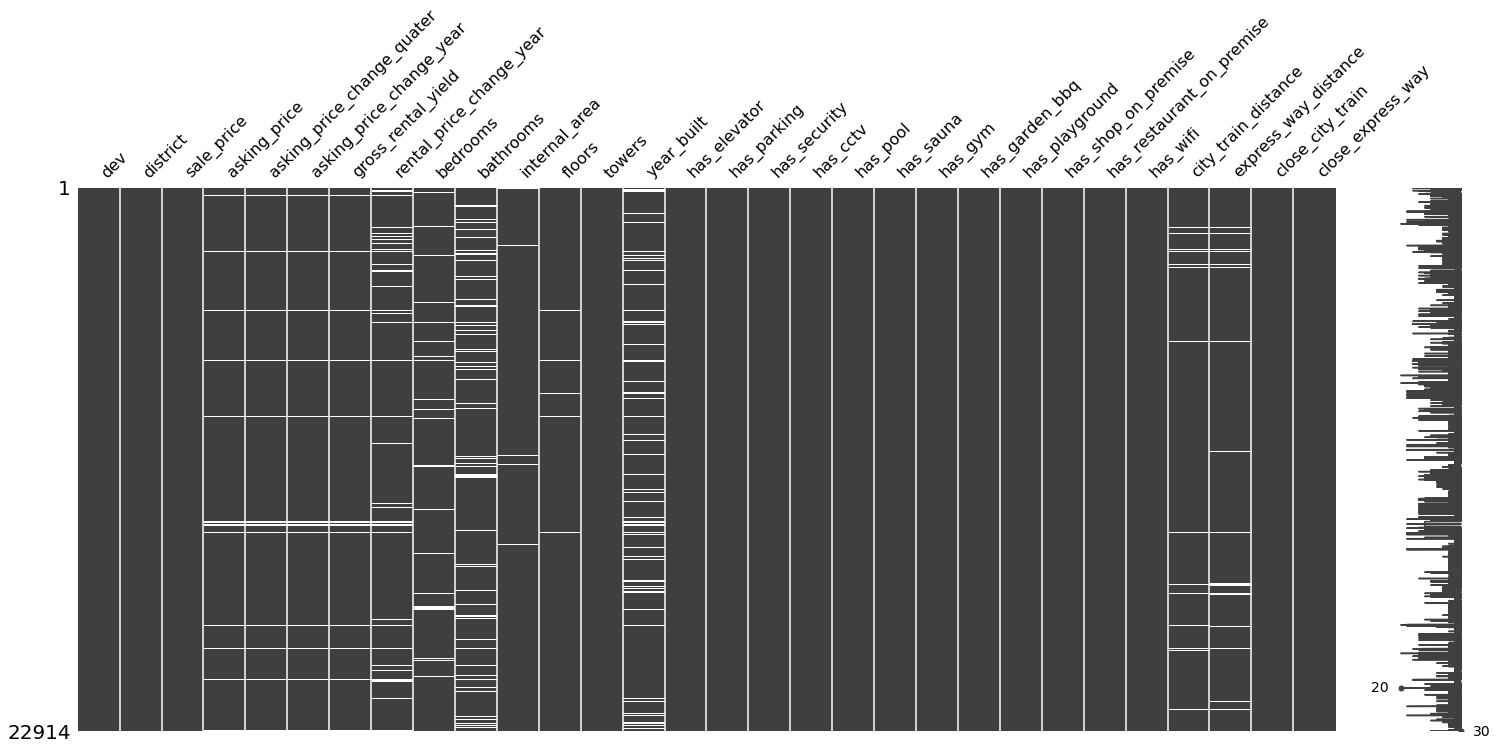

In [518]:
# Check missing values by missingno library to see patern and effect on missing data
msno.matrix(raw_df);

In [519]:
# Check if we drop rows that contain missing value
len_df = raw_df.shape[0]
len_drop_df = raw_df.drop(columns=['dev']).dropna().shape[0]
print(f"Original data: {len_df}")
print(f"Data after dropping null: {len_drop_df}")
print(f"Row loss: {len_df - len_drop_df}")
print(f"%Loss: {round((len_df - len_drop_df) / len_df * 100, 2)}")

## Original result
# Original data: 1012
# Data after dropping null: 831
# Row loss: 181
# %Loss: 17.89

Original data: 22914
Data after dropping null: 16604
Row loss: 6310
%Loss: 27.54


**As per result,** if we drop rows that contain null value, data loss will increase from 5,672 rows to 6,310 rows, which is equivalent to 27.54% loss.
<br> 16,604 remaining observations are still reasonable to solve a regression problem.

**Now we decided to leave a missing values handeling for a moment and move through EDA section to understand data behavior before going to impute or remove it.**

In [521]:
# Save clean dataframe as csv to re-use it
raw_df.to_csv('./data/condominium_price_all_clean_final.csv', index=False)

# 4. EDA
---

In [3]:
# Read saved csv file
df = pd.read_csv('./data/condominium_price_all_clean_final.csv')

In [4]:
# Set numeric features' column names
numeric_features = [
    'asking_price', 'asking_price_change_quater', 'asking_price_change_year',
    'gross_rental_yield', 'rental_price_change_year', 'bedrooms',
    'bathrooms', 'internal_area', 'floors', 'towers', 'year_built',
    'city_train_distance', 'express_way_distance']

categorical_features = [
    'bedrooms', 'bathrooms',
    'has_elevator', 'has_parking', 'has_security', 'has_cctv', 'has_pool',
    'has_sauna', 'has_gym', 'has_garden_bbq', 'has_playground',
    'has_shop_on_premise', 'has_restaurant_on_premise', 'has_wifi',
    'close_city_train', 'close_express_way']

After removing unused columns in data cleaning process, it was noticed that duplicate data was occured again even we already removed duplicate data in cleaning process from reason that the same type of rooms were built and sold separately.
<br>**To avoid data leakage from train and test datasets, we remove duplicate rooms that could be separated both in train and test dataset.**

In [7]:
# Check data loss
check_data_loss(df, df.drop_duplicates())

Original data: 22914
Data after dropping: 19986
Row loss: 2928
%Loss: 12.78


In [8]:
# Remove duplicate
df.drop_duplicates(inplace=True)

# Reset index after dropped
df.reset_index(drop=True, inplace=True)

In [9]:
df.describe().T

count        mean         std       min  \
sale_price                 19986.00 10341023.96 22514534.14 300000.00   
asking_price               19414.00   133512.91    91069.13  11212.00   
asking_price_change_quater 19414.00        0.87       27.45    -57.21   
asking_price_change_year   19404.00        1.97       15.64    -81.16   
gross_rental_yield         19414.00        4.41        1.53      0.00   
rental_price_change_year   18414.00        1.00       14.98    -94.46   
bedrooms                   19183.00        1.43        0.69      0.00   
bathrooms                  17692.00        1.42        0.82      1.00   
internal_area              19722.00       61.58       63.27      1.00   
floors                     19696.00       26.54       16.64      2.00   
towers                     19985.00        2.16        2.27      1.00   
year_built                 18111.00     2013.43        6.01   1981.00   
has_elevator               19986.00        0.98        0.13      0.00   
has_parking                19986.00        1.00        0.04      0.00   
has_security               19986.00        1.00        0.05      0.00   
has_cctv                   19986.00        0.99        0.12      0.00   
has_pool                   19986.00        0.96        0.20      0.00   
has_sauna                  19986.00        0.47        0.50      0.00   
has_gym                    19986.00        0.96        0.21      0.00   
has_garden_bbq             19986.00        0.84        0.36      0.00   
has_playground             19986.00        0.41        0.49      0.00   
has_shop_on_premise        19986.00        0.39        0.49      0.00   
has_restaurant_on_premise  19986.00        0.23        0.42      0.00   
has_wifi                   19986.00        0.48        0.50      0.00   
city_train_distance        19617.00     3095.82     3728.59      0.00   
express_way_distance       19489.00     2871.01     2257.43    150.00   
close_city_train           19986.00        0.43        0.50      0.00   
close_express_way          19986.00        0.15        0.36      0.00   

                                  25%        50%        75%          max  
sale_price                 2550000.00 4500000.00 9191500.00 580000000.00  
asking_price                 74512.00  106278.00  161472.00    780470.00  
asking_price_change_quater       0.00       0.00       0.00       664.00  
asking_price_change_year        -4.70       0.73       8.78       218.00  
gross_rental_yield               3.91       4.45       5.12        27.51  
rental_price_change_year        -5.79       1.10       7.60       130.24  
bedrooms                         1.00       1.00       2.00         8.00  
bathrooms                        1.00       1.00       2.00        24.00  
internal_area                   30.00      39.00      65.00       929.00  
floors                           8.00      27.00      37.00        77.00  
towers                           1.00       1.00       2.00        53.00  
year_built                    2010.00    2014.00    2018.00      2025.00  
has_elevator                     1.00       1.00       1.00         1.00  
has_parking                      1.00       1.00       1.00         1.00  
has_security                     1.00       1.00       1.00         1.00  
has_cctv                         1.00       1.00       1.00         1.00  
has_pool                         1.00       1.00       1.00         1.00  
has_sauna                        0.00       0.00       1.00         1.00  
has_gym                          1.00       1.00       1.00         1.00  
has_garden_bbq                   1.00       1.00       1.00         1.00  
has_playground                   0.00       0.00       1.00         1.00  
has_shop_on_premise              0.00       0.00       1.00         1.00  
has_restaurant_on_premise        0.00       0.00       0.00         1.00  
has_wifi                         0.00       0.00       1.00         1.00  
city_train_distance            560.00

## 4.1 Sale Price Outlier Check

In [10]:
# Check sale_price values
df['sale_price'].agg(['count', 'max', 'min', 'mean', 'median'])

count        19986.00
max      580000000.00
min         300000.00
mean      10341023.96
median     4500000.00
Name: sale_price, dtype: float64

Skewness: 9.660362976053605


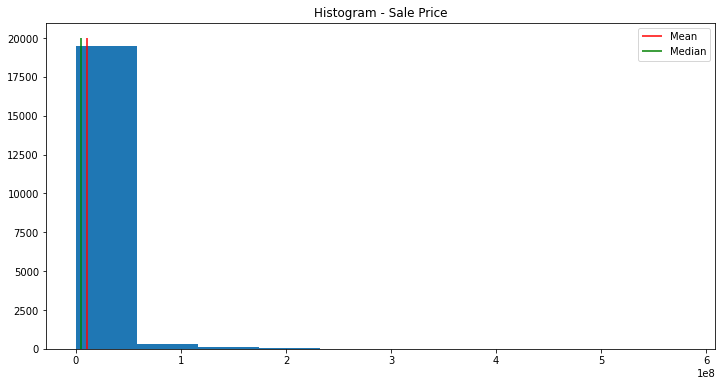

In [11]:
# Plot sale_price distribution.

print('Skewness:', df['sale_price'].skew())

plt.figure(figsize=(12, 6))
plt.hist(df['sale_price'])
plt.vlines(df['sale_price'].mean(), ymin=0, ymax=df.shape[0], color='red', label='Mean')
plt.vlines(df['sale_price'].median(), ymin=0, ymax=df.shape[0], color='Green', label='Median')
plt.title('Histogram - Sale Price')
plt.legend();


## The saleprice distribution is right skew so we could normalize it by using log e

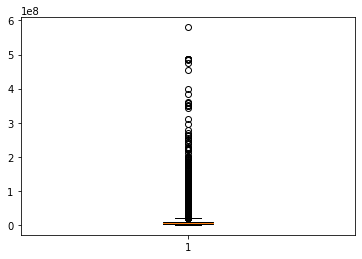

In [12]:
# Boxplot
plt.boxplot(df['sale_price']);

**Due to various characters of condominium and differences demand in each district,** condominium sale price range is extremely wide that made sale price variable has outlier values on the right hand side.

The effect of extremely wide sale price range could affect liner regression model more than other types of model.

**To minimize the effect on liner regression model we can:**
1. Remove some extreme outliers out from our dataset
2. Log transform sale price variable to normalize its scale

**To make our model precise, we focus on condominium that price lower than 10 MB**

In [13]:
# Check data loss
check_data_loss(df, df[df['sale_price'] < 10000000])

Original data: 19986
Data after dropping: 15391
Row loss: 4595
%Loss: 22.99


**Even drop data that sale price over than 10 MB, we still have 15,391 rows left.**

In [14]:
# Drop data that `sale_price` over than 10 MB
df = df[df['sale_price'] < 10000000].reset_index(drop=True)

In [15]:
# Check sale_price values
df['sale_price'].agg(['count', 'max', 'min', 'mean', 'median'])

count      15391.00
max      9995000.00
min       300000.00
mean     4026778.15
median   3450000.00
Name: sale_price, dtype: float64

Skewness: 0.7729465390333845


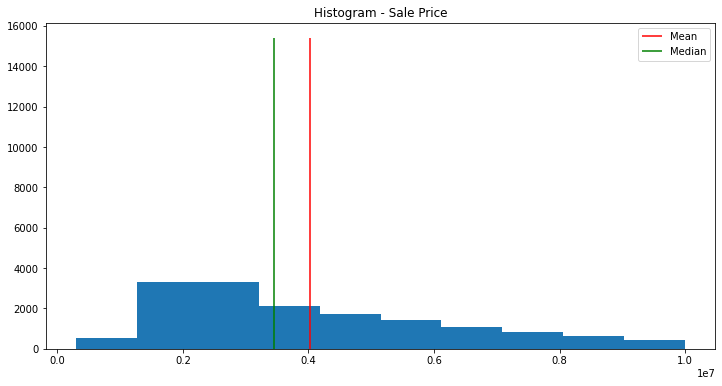

In [16]:
# Plot sale_price distribution.

print('Skewness:', df['sale_price'].skew())

plt.figure(figsize=(12, 6))
plt.hist(df['sale_price'])
plt.vlines(df['sale_price'].mean(), ymin=0, ymax=df.shape[0], color='red', label='Mean')
plt.vlines(df['sale_price'].median(), ymin=0, ymax=df.shape[0], color='Green', label='Median')
plt.title('Histogram - Sale Price')
plt.legend();


## The saleprice distribution is right skew so we could normalize it by using log e

**After dropping `sale_price` over than 10 MB,** its distribution looks more normal. comparing before and after transformation, skewness has reduced and histogram chart is also more normally distributed.

## 4.3 Correlation

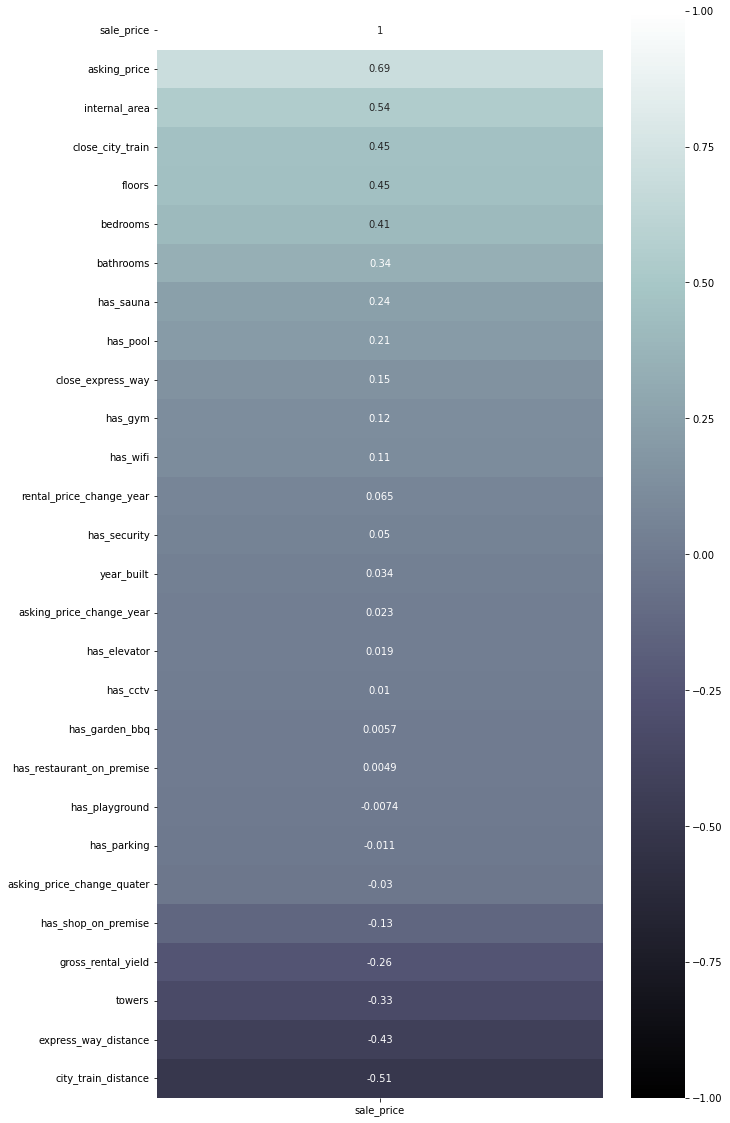

In [17]:
# Find correlation to sale_price
# Check correlation with saleprice
plt.figure(figsize=(10,20))
sns.heatmap(df.corr()[['sale_price']].sort_values(by='sale_price', ascending=False)
            , cmap='bone', annot=True, vmin=-1, vmax=1);

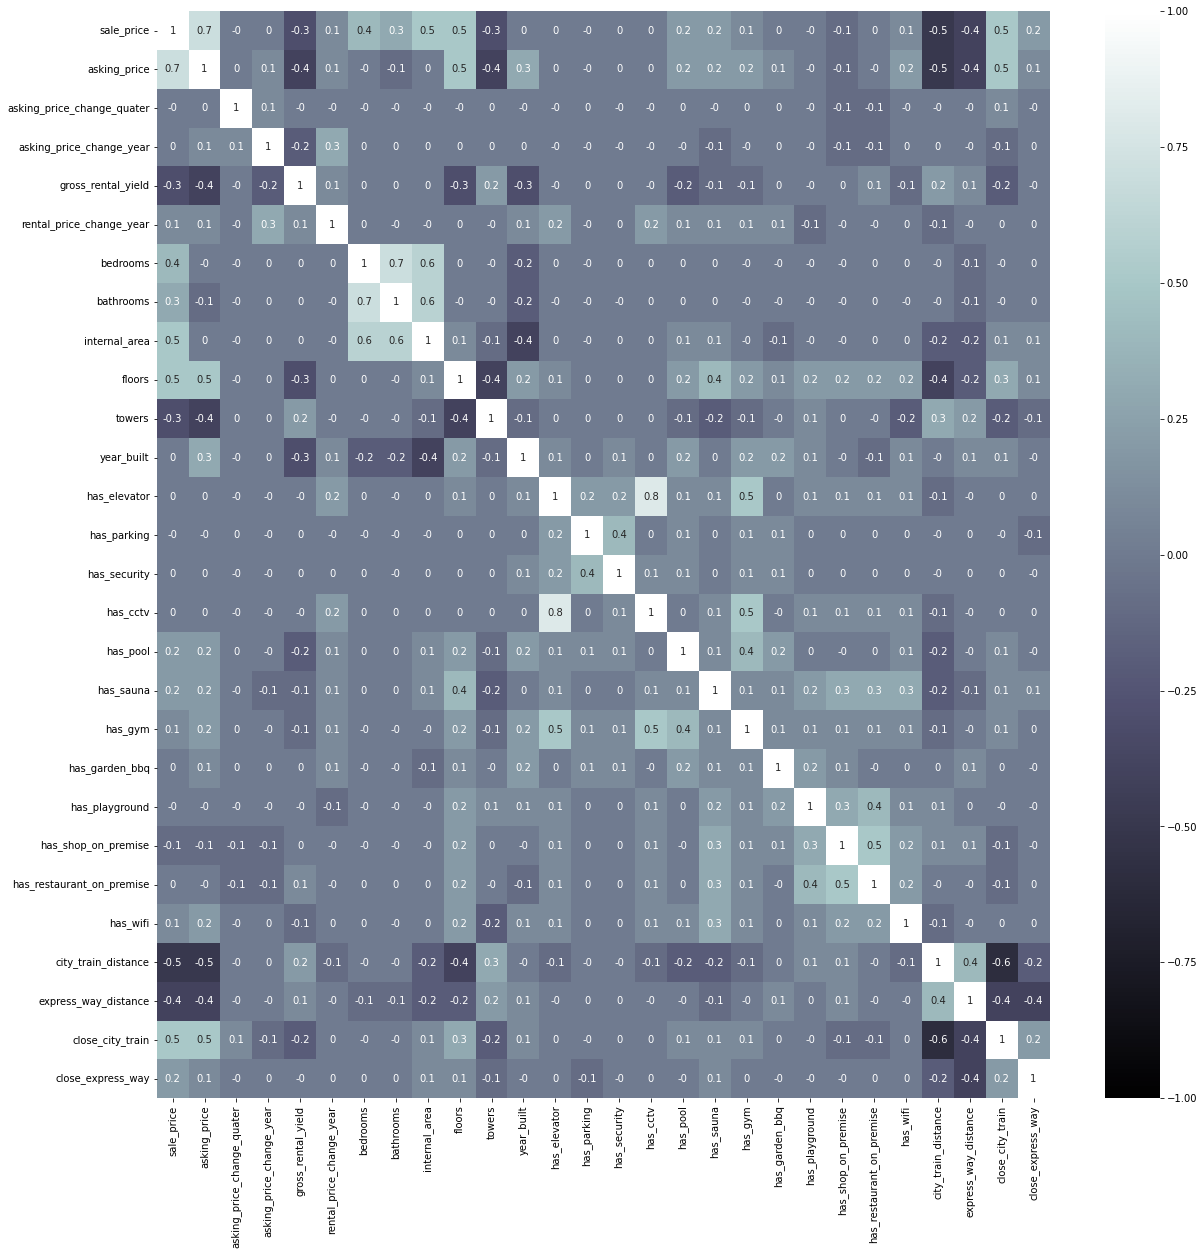

In [18]:
# Check correlation of features
plt.figure(figsize=(20,20))
sns.heatmap(df.corr().round(1), annot=True, vmin=-1, vmax=1, cmap='bone');

## 4.4 Data Characteristic

### 4.4.1 Numeric Features

In [19]:
# Print each numeric features aggregate values

for feat in numeric_features:
    print(f"""
-------------- {feat} --------------""")
    print(df[feat].agg(['count', 'max', 'min', 'mean', 'median']))
    print("-------------------------------------")
    


-------------- asking_price --------------
count     14862.00
max      780470.00
min       11212.00
mean     102819.58
median    93645.00
Name: asking_price, dtype: float64
-------------------------------------

-------------- asking_price_change_quater --------------
count    14862.00
max        664.00
min        -53.89
mean         0.86
median       0.00
Name: asking_price_change_quater, dtype: float64
-------------------------------------

-------------- asking_price_change_year --------------
count    14854.00
max        218.00
min        -81.16
mean         0.62
median       0.00
Name: asking_price_change_year, dtype: float64
-------------------------------------

-------------- gross_rental_yield --------------
count    14862.00
max         27.51
min          0.00
mean         4.62
median       4.64
Name: gross_rental_yield, dtype: float64
-------------------------------------

-------------- rental_price_change_year --------------
count    14048.00
max        130.24
min        

To understand more about relationship of `sale_price` and numeric features, we will plot `sale_price` against each features.

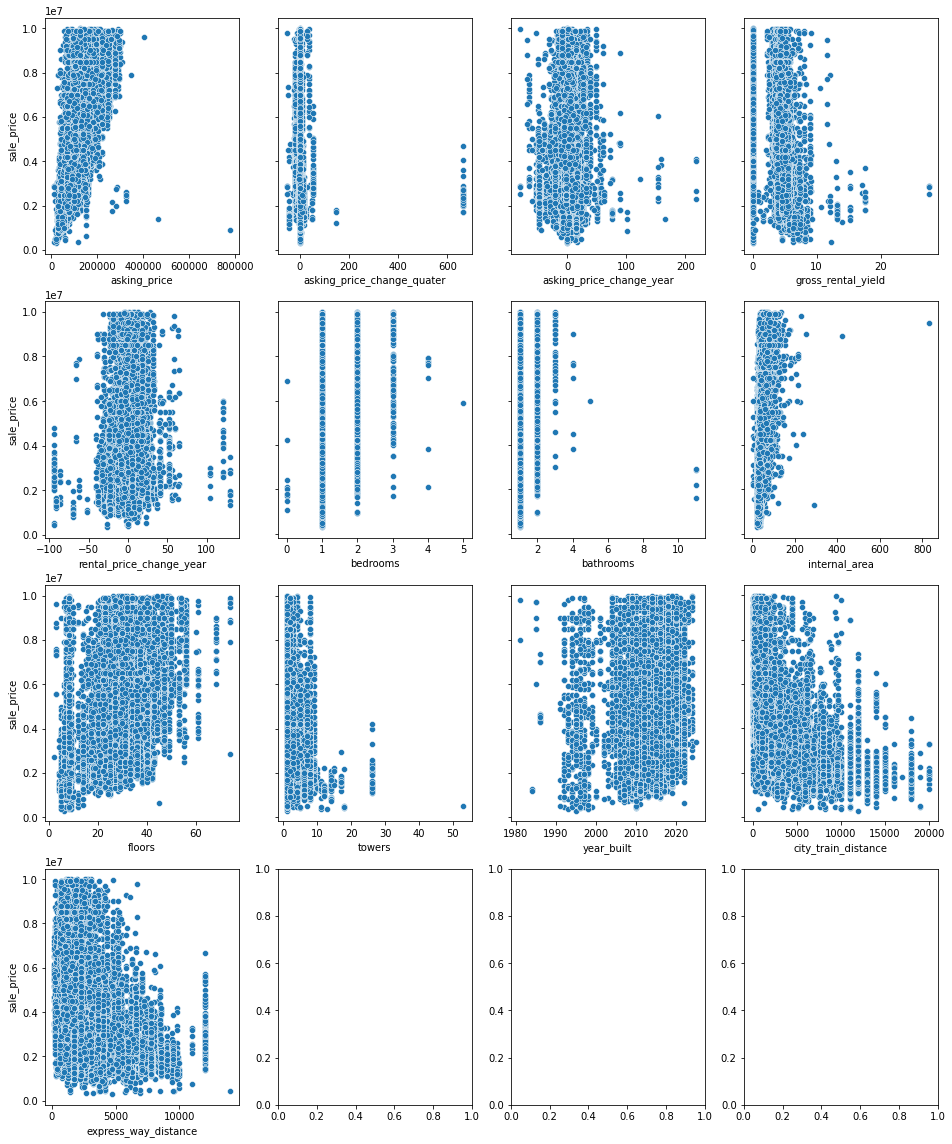

In [20]:
# Plot numeric features against saleprice.

fig, axes = plt.subplots(4, 4, figsize=(16,20))

for i, feat in enumerate(numeric_features): ## iterate column name
    x = i // 4
    y = i % 4
    pl = sns.scatterplot(
        ax=axes[x,y],
        x=feat,
        y='sale_price',
        data=df)
    if y != 0:
        pl.set(ylabel=None, yticklabels=[])  ## show label only the leftmost plot 

**Comparing `sale_price` and other numeric features,** There are some extreme outliers that are likly to affect our models, which is `internal_area` and we will explore more.

In [21]:
# Drop data that `internal_area` greater than 500
df = df[df['internal_area'] <= 500]

# Drop data that `internal_area` less than 20
df = df[df['internal_area'] >= 20]

# Reset index
df.reset_index(drop=True, inplace=True)

### 4.4.2 Categorical Features

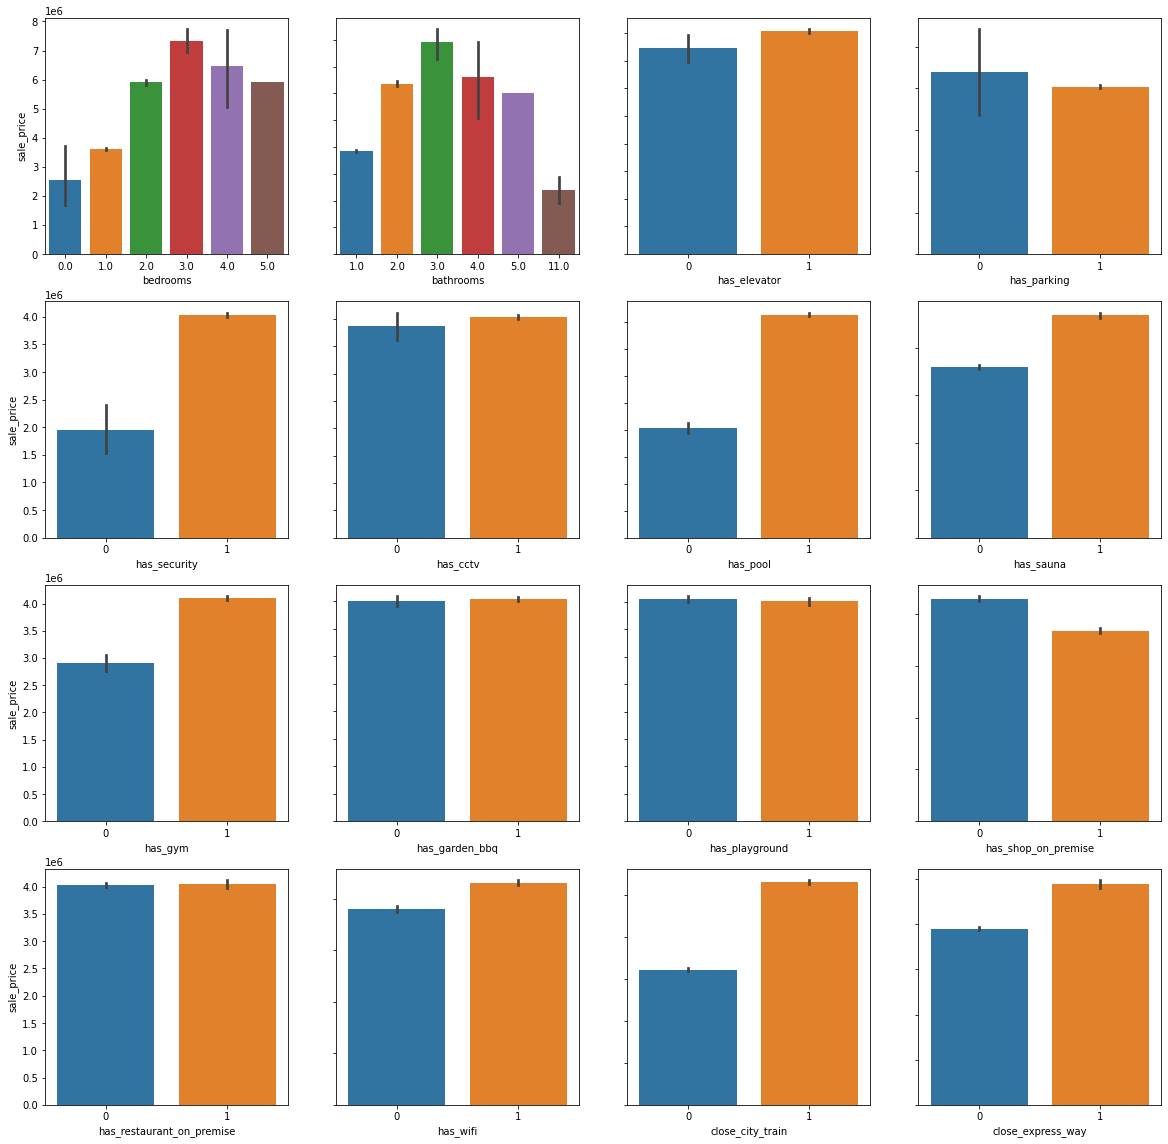

In [23]:
# Plot barchart vs. saleprice
category_chart(df, categorical_features, 'sale_price')

**From above charts,** There is one feature that have obvious different values comparing `sale_price` and the feature values as categorical data then we will explore more.

#### **`bathrooms`**
---
At number of bathrooms greater than 10, there is huge different `sale_price` value.

In [24]:
missing_bath_index = df[df['bathrooms'] > 10][['dev', 'sale_price', 'bedrooms', 'bathrooms']].index

df[df['bathrooms'] > 10][['dev', 'sale_price', 'bedrooms', 'bathrooms']]

dev  sale_price  bedrooms  bathrooms
536         Supalai Veranda Ramkhamhaeng  2199025.69      1.00      11.00
4304     The Parkland Phetkasem - Thapra  2890000.00      1.00      11.00
7098                I CONDO Sukhapiban 2  1620000.00       NaN      11.00
9961  Lumpini Place Phahol - Saphankhwai  2900000.00      1.00      11.00

- It was typo for rooms that have 11 bathrooms which should be 1 room comparing to their badrooms.

In [25]:
# 11 bathrooms - Assign new values to 1
df.loc[df[df['bathrooms'] == 11].index, 'bathrooms'] = 1

In [26]:
# Recheck result
df.loc[missing_bath_index][['dev', 'sale_price', 'bedrooms', 'bathrooms']]

dev  sale_price  bedrooms  bathrooms
536         Supalai Veranda Ramkhamhaeng  2199025.69      1.00       1.00
4304     The Parkland Phetkasem - Thapra  2890000.00      1.00       1.00
7098                I CONDO Sukhapiban 2  1620000.00       NaN       1.00
9961  Lumpini Place Phahol - Saphankhwai  2900000.00      1.00       1.00

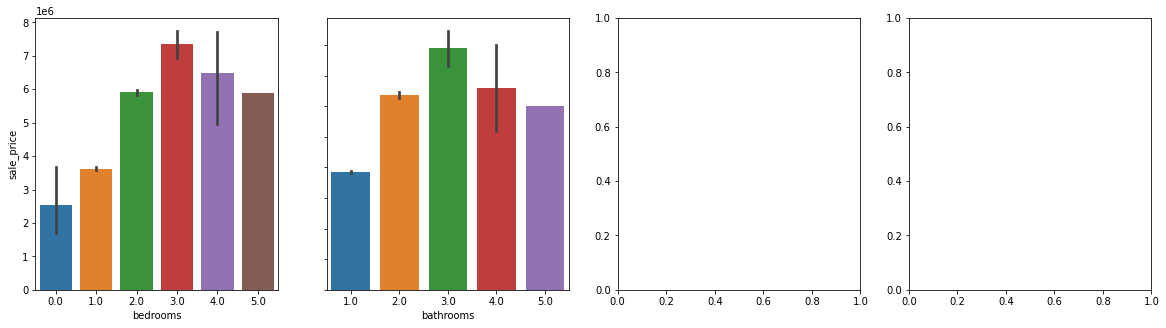

In [27]:
# Plot barchart vs. saleprice
category_chart(df, ['bedrooms', 'bathrooms'], 'sale_price')

**Now data look better**

## 4.5 Data Preparation for Modeling

**This part will create 3 types of dataframe to train models**
1. Dataframe that drop all rows that contain missing values
2. Dataframe that impute missing values by each feature median
3. Dataframe that fill missing values by 0 -> Filling 0 to missing values is good for XGBoost model

Market stats features such as `asking_price`, `rental_price`, `etc.` were decided to remove out from models because they could leave some information leakage to our features.

**To have all values for on hot encoder, all dataset will be feeded to fit one hot encoder.**

In [28]:
# Prepare for one hot encoder
oh = OneHotEncoder()
oh.fit(df[['district']])

OneHotEncoder()

### Train and Test Spliting
---
We will split train and test set first to avoid any data leakge problem.

**And to make it easier to test models' performance, we will drop null rows of our test set.**


In [29]:
# Split train and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Check split size
print('Train shape:', df_train.shape), print('Test shape:', df_test.shape)

# Drop null rows in test set
df_test = df_test.dropna().reset_index(drop=True)
print('Final test set after dropping n/a:', df_test.shape)

# Prepare features
features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
]

# Get dummy features by one hot encoder
df_dummy_district = pd.DataFrame(oh.transform(df_test[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())

# Create X and y
X_test = df_test[features].merge(df_dummy_district, left_index=True, right_index=True)
y_test = df_test['sale_price']

# y log transformation` 
y_test_log = np.log(y_test)

Train shape: (12129, 30)
Test shape: (3033, 30)
Final test set after dropping n/a: (2081, 30)


In test set, we have 2,081 data to test the models' performance, which is appropriate number of test set.

### Dataframe Type 1: 
------
Drop all rows that contain missing values



In [30]:
# Drop null rows
df_train_dropna = df_train.dropna().reset_index(drop=True)

# 'asking_price', 'asking_price_change_quater',
#     'asking_price_change_year', 'gross_rental_yield',
#     'rental_price_change_year', 
    
# Prepare features
features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
]

# Get dummy features by one hot encoder
df_dummy_district = pd.DataFrame(oh.transform(df_train_dropna[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())

# Create X and y
X_train = df_train_dropna[features].merge(df_dummy_district, left_index=True, right_index=True)
y_train = df_train_dropna['sale_price']

# y log transformation
y_train_log = np.log(y_train)

### Dataframe Type 2: 
------
Impute missing values by its median.

In [33]:
# Check features that contain missing values
missing_values_df(df_train)

n_missing  pct_missing
bathrooms                        1556        12.83
year_built                       1107         9.13
rental_price_change_year         1049         8.65
bedrooms                          586         4.83
asking_price_change_year          399         3.29
asking_price                      394         3.25
asking_price_change_quater        394         3.25
gross_rental_yield                394         3.25
express_way_distance              341         2.81
city_train_distance               244         2.01
floors                            193         1.59
towers                              1         0.01

In [34]:
# Prepare dataframe for imputing median
df_train_median = df_train.copy().reset_index(drop=True)


# Impute interger features
missing_features = missing_values_df(df_train_median).index

for feat in missing_features:
    df_train_median[feat].fillna(df_train_median[feat].median(), inplace=True)

features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
]

# Get dummy features by one hot encoder
df_dummy_district_train = pd.DataFrame(oh.transform(df_train_median[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())

# Create train and test sets
X_train_median = df_train_median[features].merge(df_dummy_district_train, left_index=True, right_index=True)
y_train_median = df_train_median['sale_price']

# y log transformation
y_train_median_log = np.log(y_train_median)

In [35]:
# Check result train set
missing_values_df(df_train_median)

Empty DataFrame
Columns: [n_missing, pct_missing]
Index: []

### Dataframe Type 3: 
------
Fill null values with zero



In [36]:
# Prepare data for filling zero
df_train_zero = df_train.copy().reset_index(drop=True)

# Fil missing values with zero
df_train_zero.fillna(value=0, inplace=True)

# Create X, y
features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
]

# Get dummy features by one hot encoder
df_dummy_district = pd.DataFrame(oh.transform(df_train_zero[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())

# Create X and y
X_train_zero = df_train_zero[features].merge(df_dummy_district, left_index=True, right_index=True)
y_train_zero = df_train_zero['sale_price']

# y log transformation
y_train_zero_log = np.log(y_train_zero)

# 5. Modeling and Evaluation
---

## 5.1 Linear Regression Models
To squeeze performance of linear regression based models, feature selection and feature engineering will paly important role of this section.

### Base Model: Using all features
---

#### 1. Drop missing values

In [40]:
# Regression with drop n/a
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate
reg_metrics(lr, X_train, X_test, y_train, y_test)

-----------Train Data-----------
MAE: 792596.7588550014
MSE: 1205879977888.0186
RMSE: 1098125.6657996927
R2: 0.7743224712922308
Cross Validation: [0.78433847 0.76433307 0.76699657 0.76476646 0.76906828]
Cross Validation Mean: 0.7699005696550192
--------------------------------
-----------Test Data-----------
MAE: 789161.8067344745
MSE: 1134700198801.573
RMSE: 1065223.0746663222
R2: 0.7850897039389284
--------------------------------


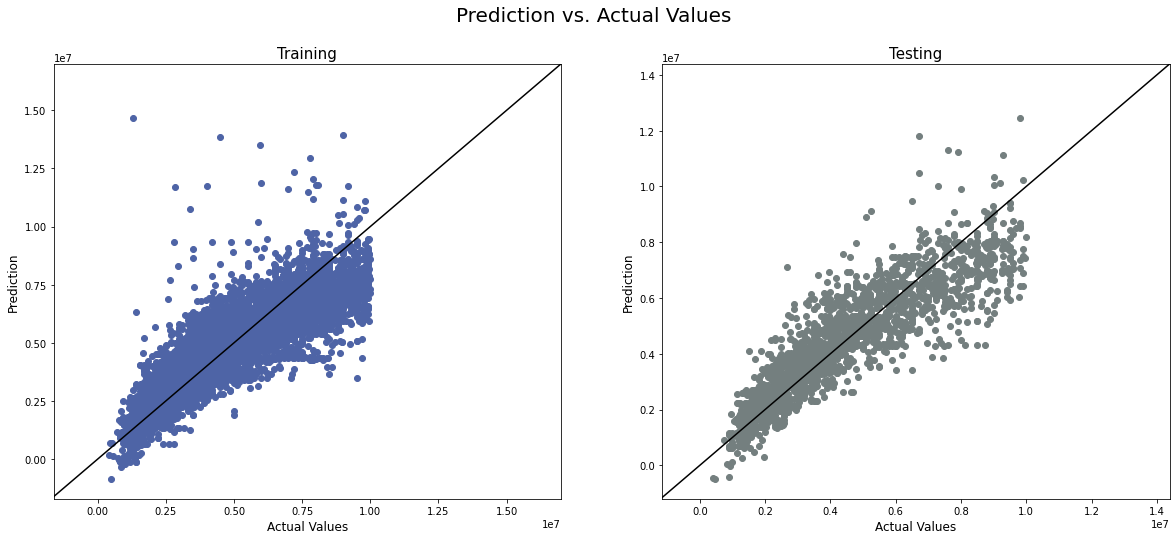

In [41]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(lr, X_train, X_test, y_train, y_test)

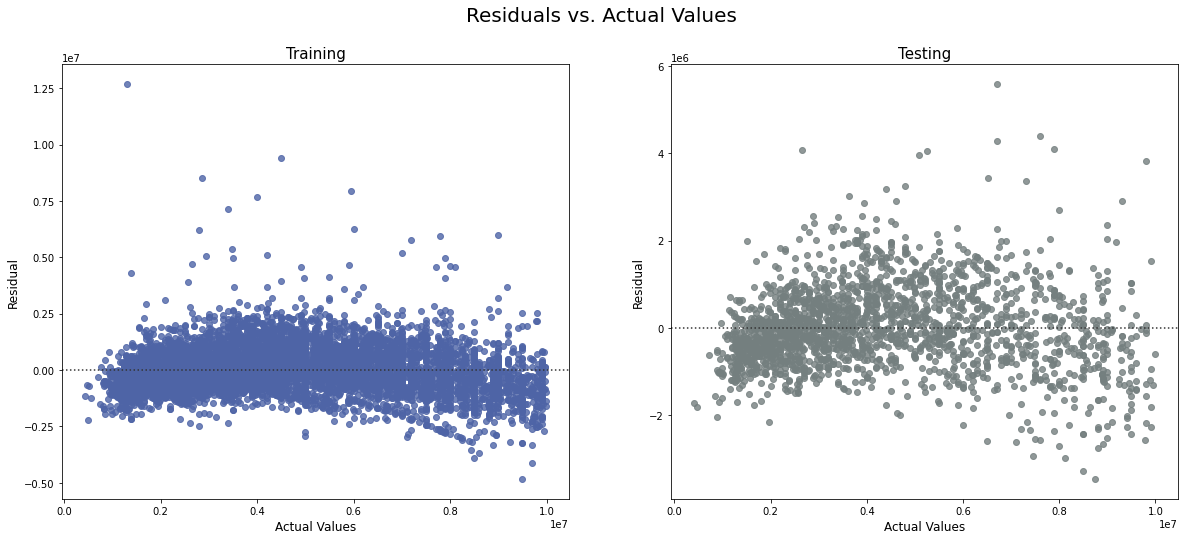

In [44]:
plot_residual(lr, X_train, X_test, y_train, y_test)

#### 2. Fill missing values with median

In [119]:
# Regression with median imputation
lr = LinearRegression()
lr.fit(X_train_median, y_train_median)
reg_metrics(lr, X_train_median, X_test, y_train_median, y_test)

-----------Train Data-----------
MAE: 763794.8732160593
MSE: 1163488427964.1748
RMSE: 1078651.207742417
R2: 0.7708924499925005
Cross Validation: [0.78296268 0.7344775  0.7699003  0.76791467 0.77793024]
Cross Validation Mean: 0.7666370765928885
--------------------------------
-----------Test Data-----------
MAE: 794432.0127797697
MSE: 1168807495225.5908
RMSE: 1081114.0065809854
R2: 0.7786298397562395
--------------------------------


#### 3. Fill missing values with zero

In [120]:
# Regression with filling zero
lr = LinearRegression()
lr.fit(X_train_zero, y_train_zero)
reg_metrics(lr, X_train_zero, X_test, y_train_zero, y_test)

-----------Train Data-----------
MAE: 844396.6365034028
MSE: 1323011748256.033
RMSE: 1150222.477721607
R2: 0.739480021469185
Cross Validation: [0.74827471 0.71269731 0.74317897 0.73794617 0.7376411 ]
Cross Validation Mean: 0.7359476506857006
--------------------------------
-----------Test Data-----------
MAE: 897087.6666850287
MSE: 1415020438436.233
RMSE: 1189546.3162215387
R2: 0.7319975252688073
--------------------------------


**Note:** Comparing 3 dataset for test results
1. Drop missing values -> `R-squared:` **1,098,125** `RMSE:` **0.78**
2. Fill missing with median -> `R-squared:` **1,081,114** `RMSE:` **0.77**
3. Fill missing with zero -> `R-squared:` **1,189,546** `RMSE:` **0.73**

**In summary,** Dataset with dropping null rows and filling with median perform similar performance.

### Linear Regression with Log Transformation
---
Due to `sale_price` outliers existing in our dataset, we first try to log transformation values to minimize its scale and then model with normal linear regression.

In [45]:
lr_log_y = LinearRegression()
lr_log_y.fit(X_train, y_train_log)

# Evaluate
reg_metrics(lr_log_y, X_train, X_test, y_train_log, y_test_log, log_y=True)

-----------Train Data-----------
MAE: 829151.9079296857
MSE: 2164442715182.4417
RMSE: 1471204.5116782512
R2: 0.8112335662599106
Cross Validation: [0.81738313 0.80300674 0.80924631 0.79359075 0.81117654]
Cross Validation Mean: 0.8068806927798032
--------------------------------
-----------Test Data-----------
MAE: 819678.3595500089
MSE: 1663028439185.4912
RMSE: 1289584.5994681742
R2: 0.8214731602476095
--------------------------------


From log transformation of `sale_price`, a model performance seems to perform better than baseline model considering R-squared **but** it turns out that converted (exponential) RMSE is similar to baseline model that is `R^2:` **0.82** `RMSE:` **1,289,584** for test set.

#### Residual Analysis
---
To explore more, we plot **predicted values vs. actual values** of `sale_price` both in log transformation and converted as normal unit by taking exponential.

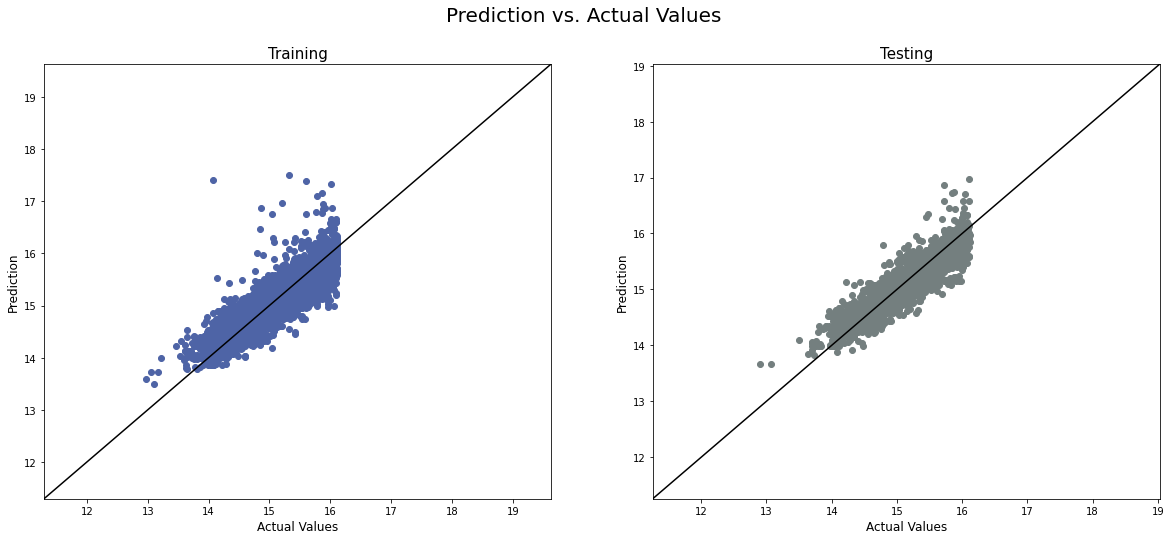

In [46]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(lr_log_y, X_train, X_test, y_train_log, y_test_log)

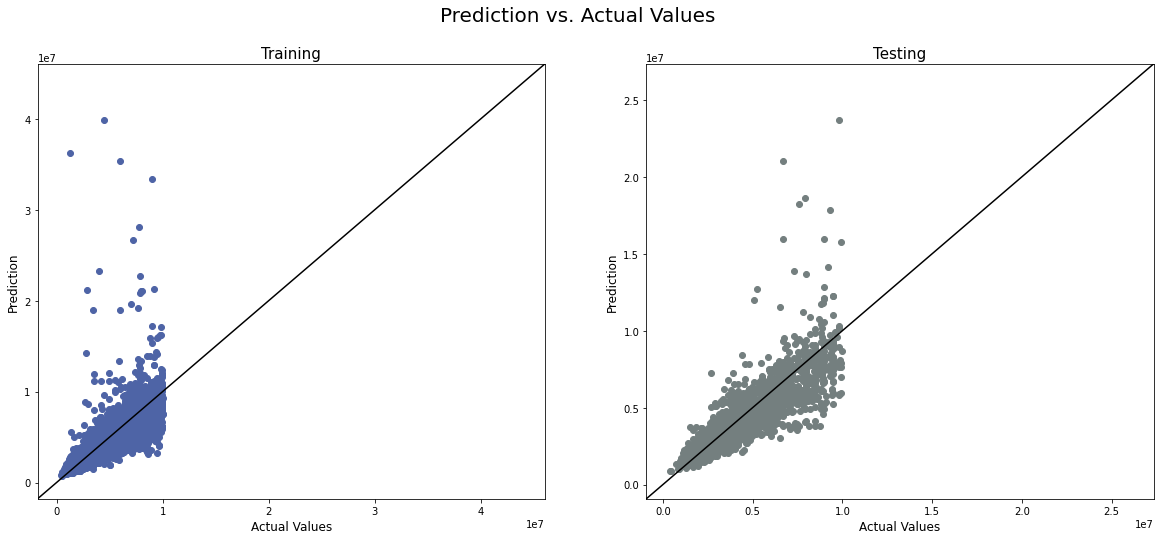

In [47]:
# Plot exponential of log actual target vs. exponential of log predicted target
plot_ytrue_ypred(lr_log_y, X_train, X_test, y_train_log, y_test_log, mode='exp')

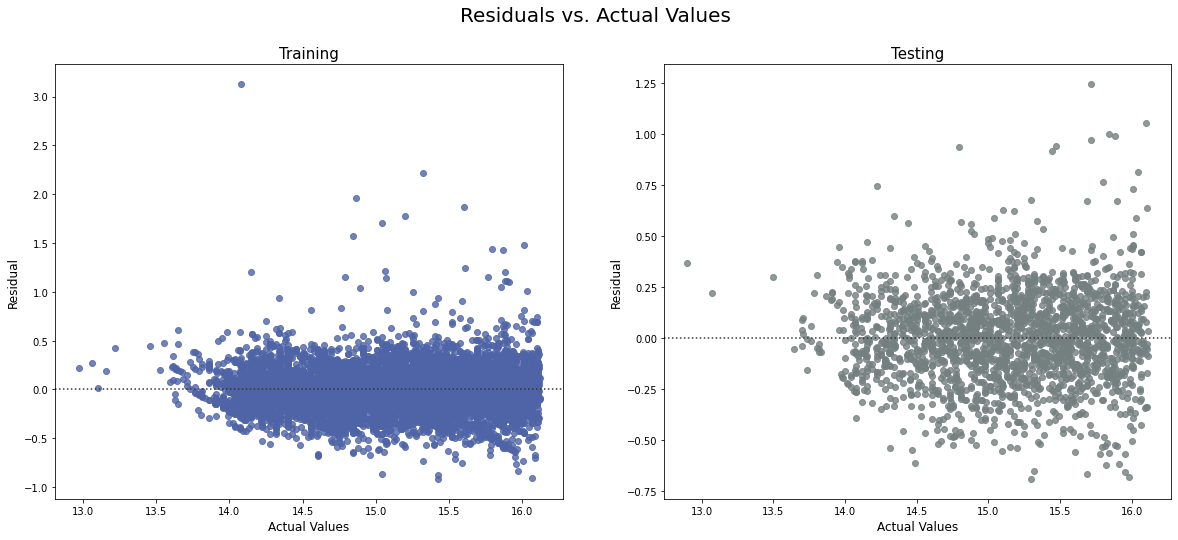

In [48]:
plot_residual(lr_log_y, X_train, X_test, y_train_log, y_test_log)

The result of above charts show that after exponential converting of log model, **extremely high `sale_price` were predicted on the high actual `sale_price` values.**

Also residual plot shows that on the riht hand side of chart, which is high actual `sale_price` values have wide range of residual and most of them are negative values that means **our model does not perform well when facing very expensive price condominiums.**

**AS prior information that our dataset contains a lot of high outliers, we could remove it and see our models' performance.**

#### Outliers Removal
---

We first try to remove outliers from dataset that we dropped null rows, which is dataset that can make a current linear regression model perform the best.

Skewness: 0.6090145468562355


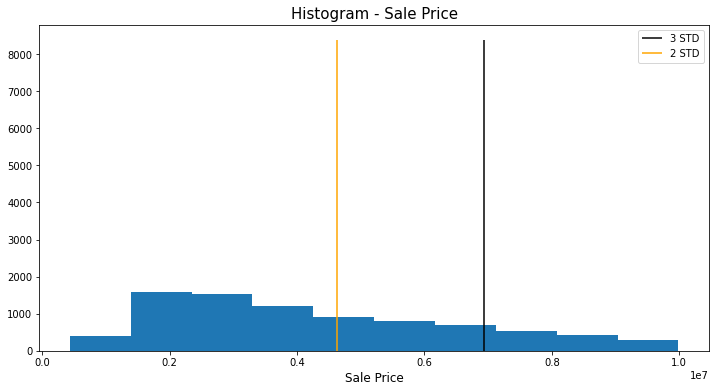

In [49]:
# Plot sale_price distribution.
print('Skewness:', df_train_dropna['sale_price'].skew())

sale_price_std = df_train_dropna['sale_price'].std()

plt.figure(figsize=(12, 6))
plt.hist(df_train_dropna['sale_price'])
plt.vlines(sale_price_std*3, ymin=0, ymax=df_train_dropna.shape[0], color='black', label='3 STD')
plt.vlines(sale_price_std*2, ymin=0, ymax=df_train_dropna.shape[0], color='orange', label='2 STD')
plt.title('Histogram - Sale Price', size=15)
plt.xlabel('Sale Price', size=12)
plt.legend();

In [50]:
# Check number of data that > 3std
print("\n--- Drop data using 3 STD of sale_price ---")
check_data_loss(df_train_dropna, df_train_dropna[df_train_dropna['sale_price'] <= sale_price_std*3])

print("\n--- Drop data using 2 STD of sale_price ---")
check_data_loss(df_train_dropna, df_train_dropna[df_train_dropna['sale_price'] <= sale_price_std*2])


--- Drop data using 3 STD of sale_price ---
Original data: 8375
Data after dropping: 7025
Row loss: 1350
%Loss: 16.12

--- Drop data using 2 STD of sale_price ---
Original data: 8375
Data after dropping: 5105
Row loss: 3270
%Loss: 39.04


**Result:** 
<br>If we drop rows that `sale_price` greater than 3 STD, data will loss only 2.01%.
<br>if we drop data by 2 STD we will loss 3.82% of our data.

**We can try the hardest way of removing outlier by using 2 STD criteria that we will lose only 3.82% of data.**

In [51]:
# Drop outliers by 2 STD of sale_price
df_train_dropna_2std = df_train_dropna[df_train_dropna['sale_price'] <= sale_price_std*2].reset_index(drop=True)

# Prepare features
features = [
    'bedrooms', 'bathrooms', 'internal_area',
    'floors', 'towers', 'year_built', 'has_elevator', 'has_parking',
    'has_security', 'has_cctv', 'has_pool', 'has_sauna', 'has_gym',
    'has_garden_bbq', 'has_playground', 'has_shop_on_premise',
    'has_restaurant_on_premise', 'has_wifi', 'city_train_distance',
    'express_way_distance', 'close_city_train', 'close_express_way'
]

# Get dummy features by one hot encoder
df_dummy_district = pd.DataFrame(oh.transform(df_train_dropna_2std[['district']]).toarray(),
                                 columns=oh.get_feature_names_out())

# Create X and y
X_train_2std = df_train_dropna_2std[features].merge(df_dummy_district, left_index=True, right_index=True)
y_train_2std = df_train_dropna_2std['sale_price']


# y log transformation
y_train_log_2std = np.log(y_train_2std)

In [52]:
# Linear regression with normal y
lr_2std = LinearRegression()
lr_2std.fit(X_train_2std, y_train_2std)

# Evaluation use the original test dataset
reg_metrics(lr_2std, X_train_2std, X_test, y_train_2std, y_test)

-----------Train Data-----------
MAE: 424384.51990689157
MSE: 309930511785.5992
RMSE: 556714.0305269836
R2: 0.6787217449878618
Cross Validation: [0.67677513 0.61389648 0.67766021 0.66596542 0.68433671]
Cross Validation Mean: 0.6637267894321826
--------------------------------
-----------Test Data-----------
MAE: 1173390.3406623353
MSE: 2887466874124.2476
RMSE: 1699254.7996472593
R2: 0.45311866390789757
--------------------------------


In [53]:
# Linear regression with logtranformation
lr_2std = LinearRegression()
lr_2std.fit(X_train_2std, y_train_log_2std)

# Evaluation use the original test dataset
reg_metrics(lr_2std, X_train_2std, X_test, y_train_log_2std, y_test_log, log_y=True)

-----------Train Data-----------
MAE: 449391.1790066548
MSE: 592091606673.368
RMSE: 769474.8902162877
R2: 0.6904713577140954
Cross Validation: [0.6846863  0.62278383 0.69362512 0.67138796 0.69564187]
Cross Validation Mean: 0.6736250161831709
--------------------------------
-----------Test Data-----------
MAE: 1004814.5966467746
MSE: 2210103143938.094
RMSE: 1486641.5653876
R2: 0.737825387896397
--------------------------------


**Removing outlier can not make our linear regression models perform better** because removing outliers from training dataset can prevent our model to learn very high values of target to predict test set.

## 5.2 Random Forest Models

### Random Forest - Drop missing values
---

In [54]:
# Try log transformation
rfr_test = RandomForestRegressor(random_state=42)

rfr_test.fit(X_train, y_train)

reg_metrics(rfr_test, X_train, X_test, y_train, y_test, cross_val=False)

-----------Train Data-----------
MAE: 247559.2011264089
MSE: 129230152140.25912
RMSE: 359485.9554144767
R2: 0.9758148887913196
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 473288.94485072396
MSE: 479783670237.1519
RMSE: 692664.1828744662
R2: 0.9091297853610715
--------------------------------


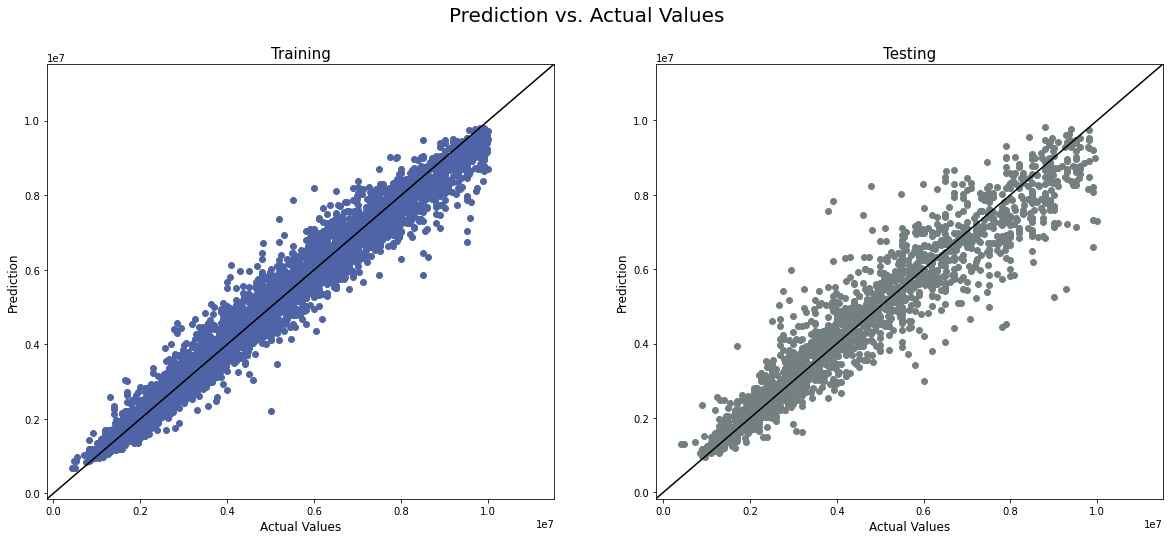

In [55]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(rfr_test, X_train, X_test, y_train, y_test)

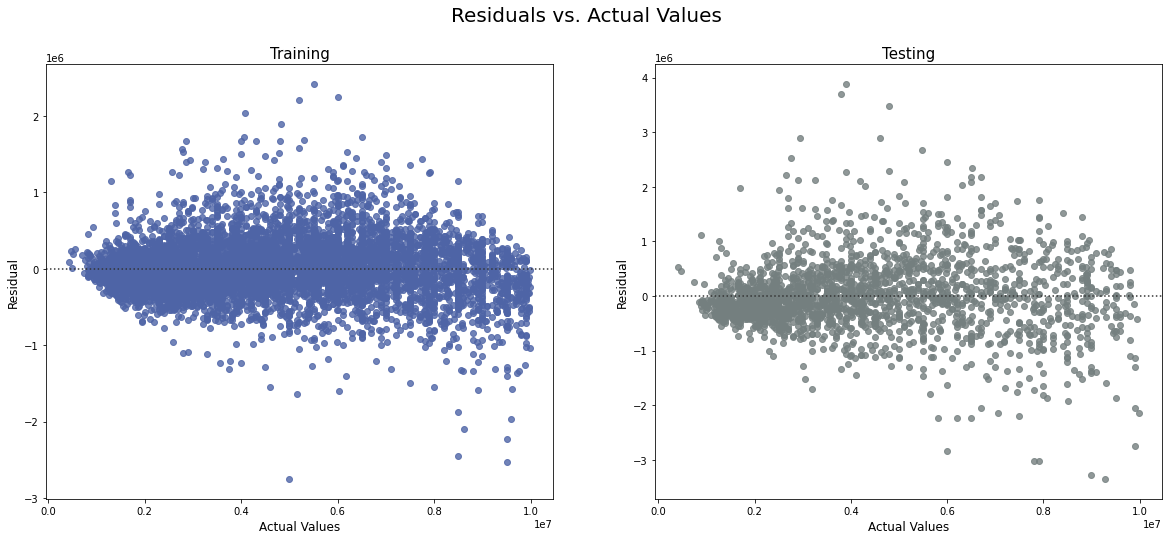

In [56]:
plot_residual(rfr_test, X_train, X_test, y_train, y_test)

**Without any hyperparameters tuning our model still perform well**, from `RMSE:` **1,098,125** of our best linear regression model to `RMSE:` **692,664** of test set.

### Random Forest - Log transformation and drop missing values
---
Using log `sale_price`

In [57]:
# Try log transformation
rfr_log = RandomForestRegressor(random_state=42)

rfr_log.fit(X_train, y_train_log)

reg_metrics(rfr_log, X_train, X_test, y_train_log, y_test_log, log_y=True, cross_val=False)

-----------Train Data-----------
MAE: 248405.99019509665
MSE: 133515203715.50023
RMSE: 365397.32308201195
R2: 0.9775413800410934
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 471789.37351273256
MSE: 490718248949.3637
RMSE: 700512.8470980127
R2: 0.9255481880373491
--------------------------------


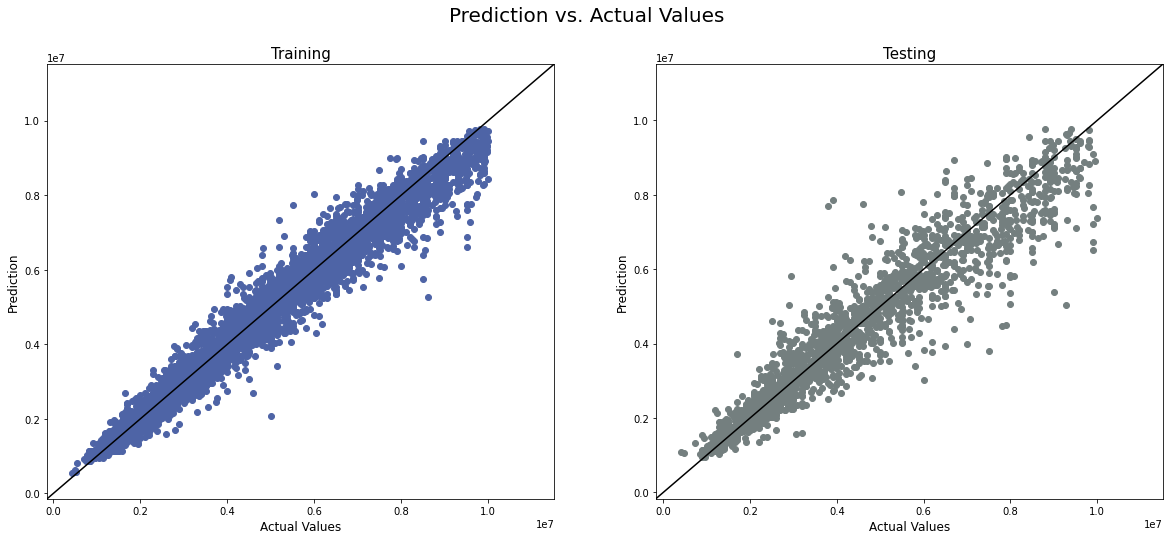

In [58]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(rfr_log, X_train, X_test, y_train_log, y_test_log, mode='exp')

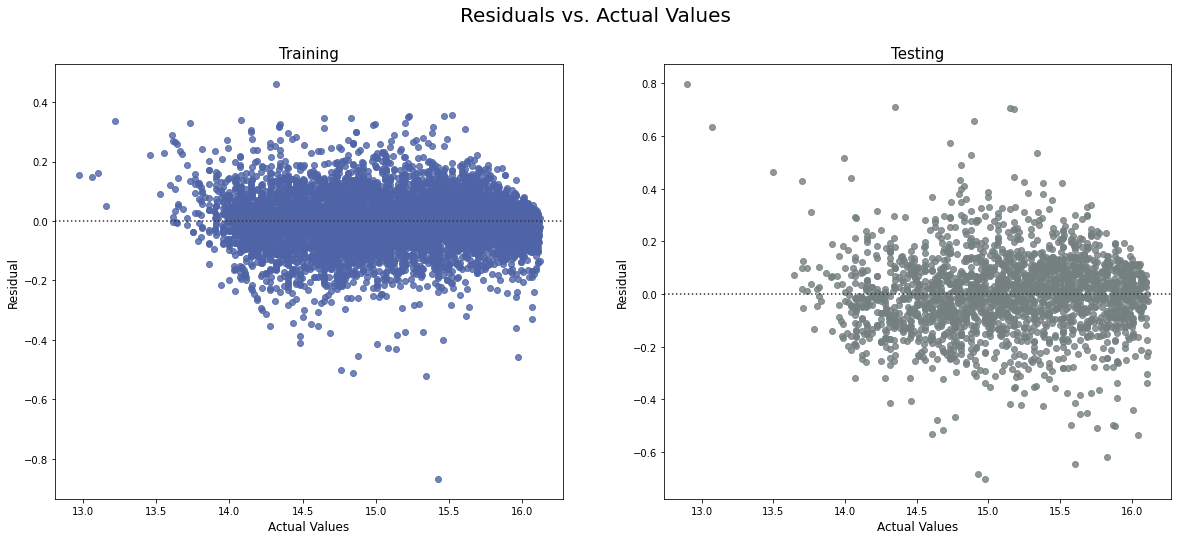

In [59]:
plot_residual(rfr_log, X_train, X_test, y_train_log, y_test_log)

Random Forest with log transformation can also perform well but not better than normal Random Forest.

### Random Forest - Dataset filling null with median
---

In [60]:
# Model
rfr_median = RandomForestRegressor(random_state=42)
rfr_median.fit(X_train_median, y_train_median)

# Evaluate
reg_metrics(rfr_median, X_train_median, X_test, y_train_median, y_test, cross_val=False)

-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 462566.86907576234
MSE: 459919687818.3884
RMSE: 678173.7888022424
R2: 0.9128919899919309
--------------------------------


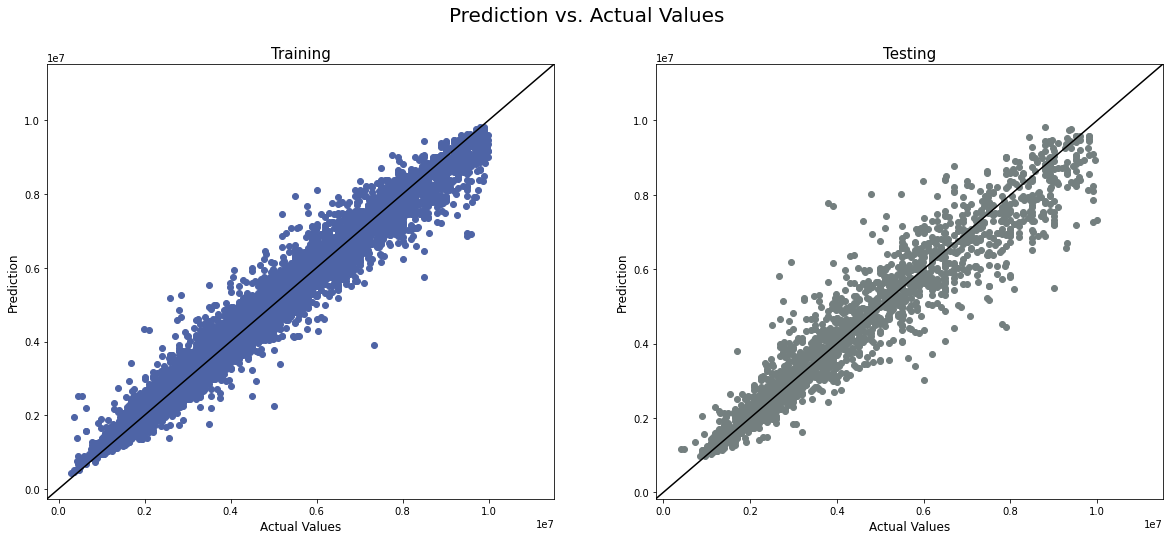

In [61]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(rfr_median, X_train_median, X_test, y_train_median, y_test)

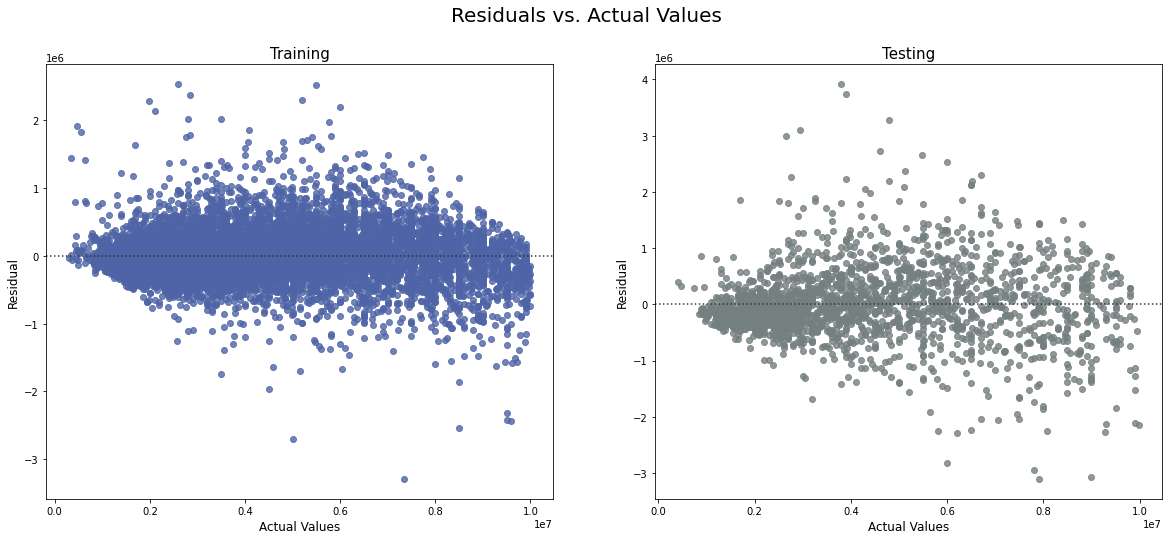

In [62]:
plot_residual(rfr_median, X_train_median, X_test, y_train_median, y_test)

### Random Forest - Dataset filling null with zero
---

In [63]:
# Model
rfr_zero = RandomForestRegressor(random_state=42)
rfr_zero.fit(X_train_zero, y_train_zero)

# Evaluate
reg_metrics(rfr_zero, X_train_zero, X_test, y_train_zero, y_test, cross_val=False)

-----------Train Data-----------
MAE: 228993.81263668305
MSE: 116938534405.39822
RMSE: 341962.7675718487
R2: 0.9769731262682456
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 468706.57758560387
MSE: 473096853865.1107
RMSE: 687820.3645321289
R2: 0.9103962570579471
--------------------------------


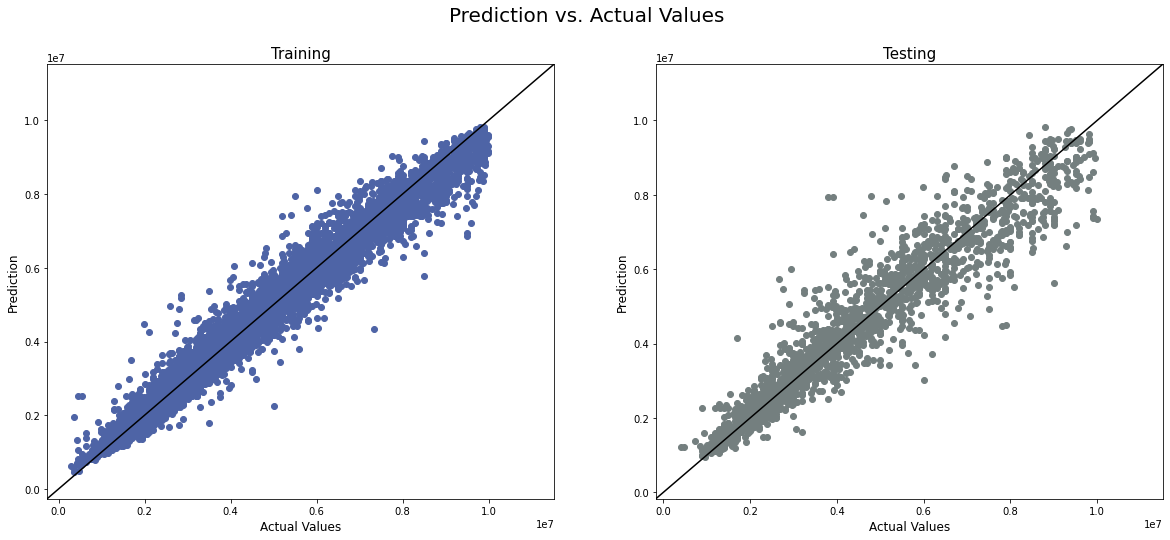

In [64]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(rfr_zero, X_train_zero, X_test, y_train_zero, y_test)

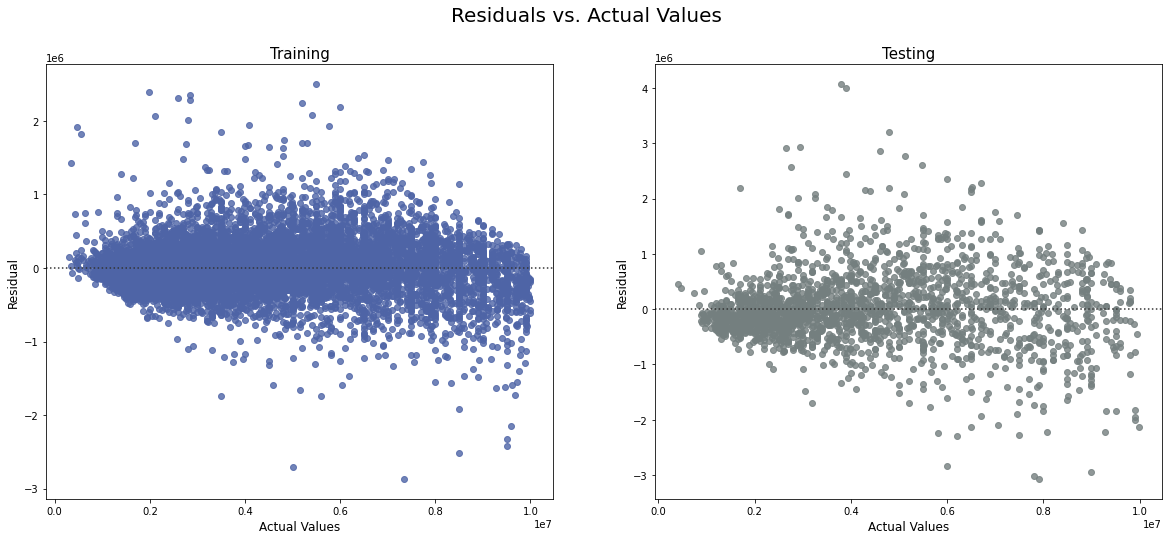

In [65]:
plot_residual(rfr_zero, X_train_zero, X_test, y_train_zero, y_test)

**Summary:** Without tuning, Random Forest with drop null values dataset perform the best.

### Random Forest with GridSearch
---
We will use GridSearch to find best parameters without log transformation of y.

In [154]:
%%time
# Set hyperparametesr
hyper_params = {'max_depth': [5, 10, 15],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [100, 200]
               }

# Instantiate GridSearchCV
rfr_gridsearch = GridSearchCV(RandomForestRegressor(),
                              hyper_params,
                              cv=5,
                              verbose=1
                             )

# Fit train data
rfr_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 10min 19s
Wall time: 10min 19s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)

In [155]:
rfr_gridsearch.best_params_

{'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 200}

In [156]:
# Evaluation
reg_metrics(rfr_gridsearch, X_train, X_test, y_train, y_test, cross_val=False)

-----------Train Data-----------
MAE: 356969.8843752061
MSE: 264830523925.2701
RMSE: 514616.87100722815
R2: 0.9504376063441127
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 490791.20556825586
MSE: 510054815167.98083
RMSE: 714181.2201171218
R2: 0.9033964817747471
--------------------------------


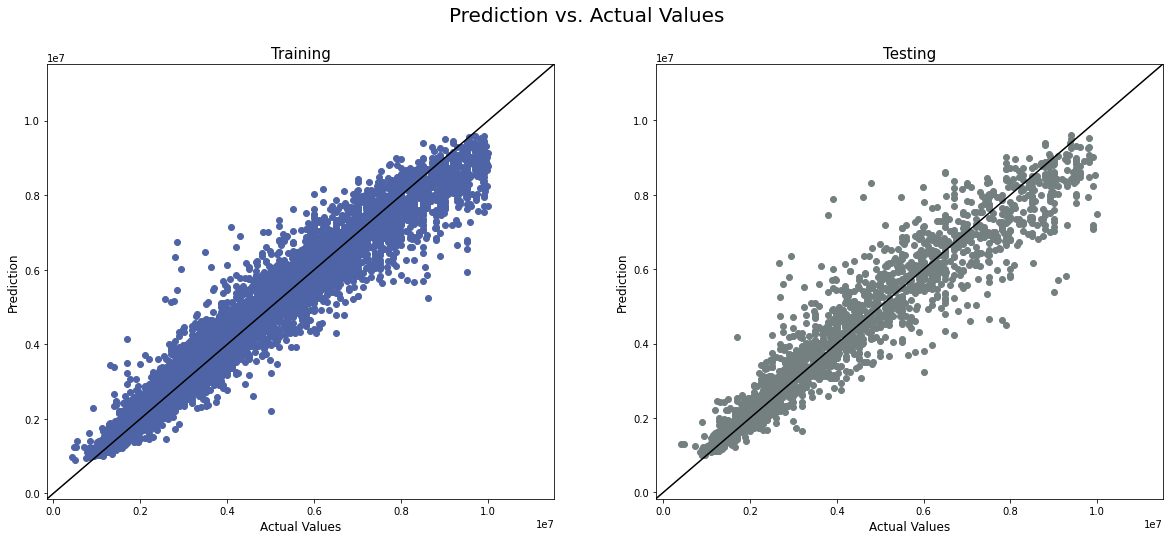

In [177]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(rfr_gridsearch, X_train, X_test, y_train, y_test)

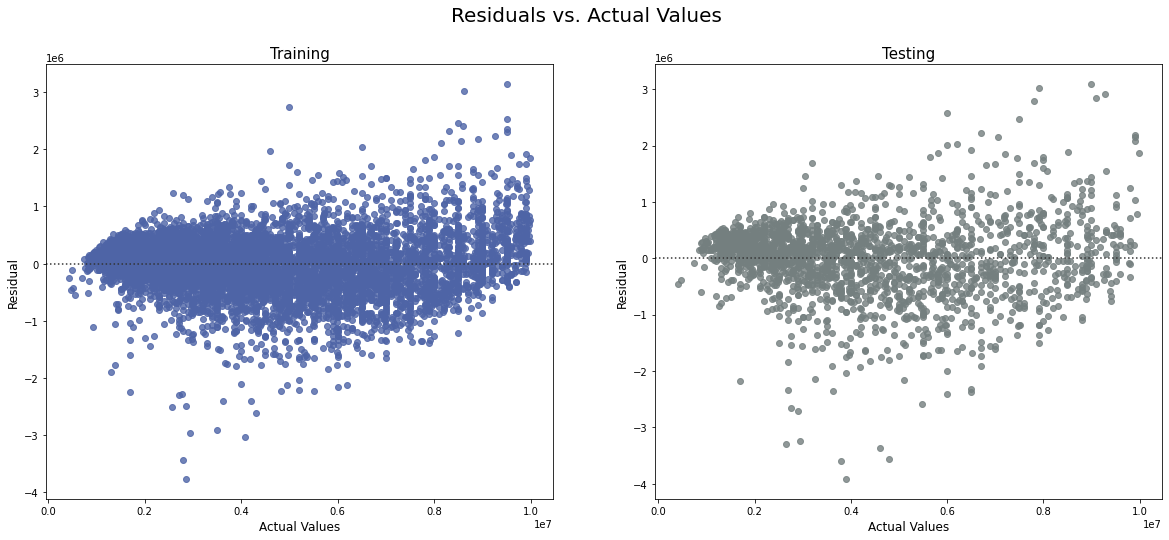

In [178]:
plot_residual(rfr_gridsearch, X_train, X_test, y_train, y_test)

**Result:** GridSearch for hyperparameters tuning can slightly improve our Random Forest model .

## 5.3 XGBoost

### Normal XGBoost
---
To seek more perdictive power, we use **Extreme Gradient Boosting** technic, which is also tree based model.

In [66]:
%%time
xgbr = xgboost.XGBRegressor(seed=42)

xgbr.fit(X_train, y_train)

CPU times: total: 4.56 s
Wall time: 1.52 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [67]:
reg_metrics(xgbr, X_train, X_test, y_train, y_test, cross_val=False)

-----------Train Data-----------
MAE: 343555.3873059701
MSE: 226679986018.43573
RMSE: 476109.21648129827
R2: 0.9575773874761997
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 477191.04629685247
MSE: 471545789461.9661
RMSE: 686691.9174287448
R2: 0.9106900260292063
--------------------------------


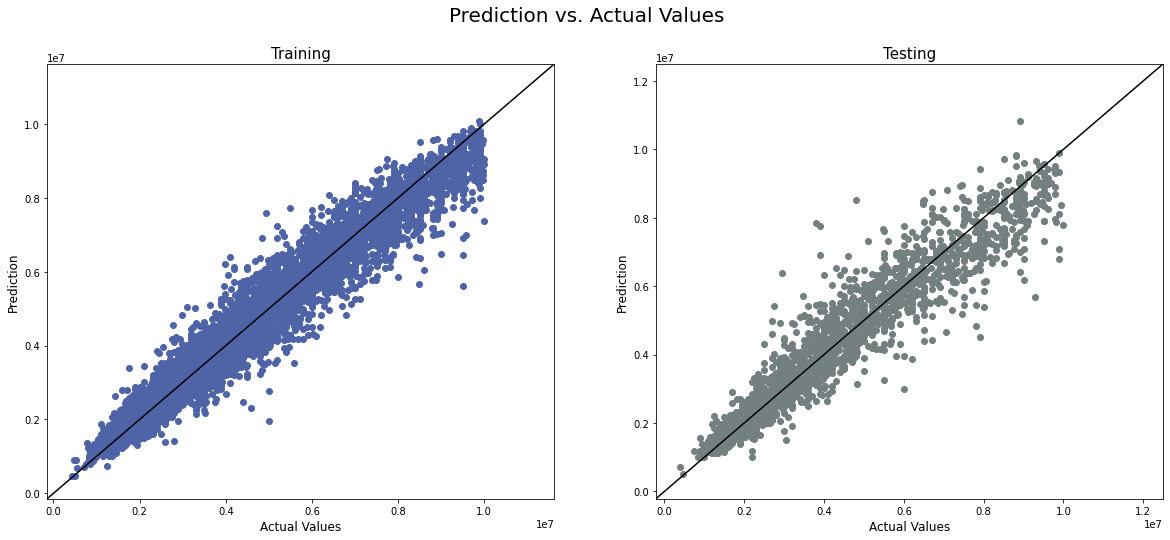

In [68]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(xgbr, X_train, X_test, y_train, y_test)

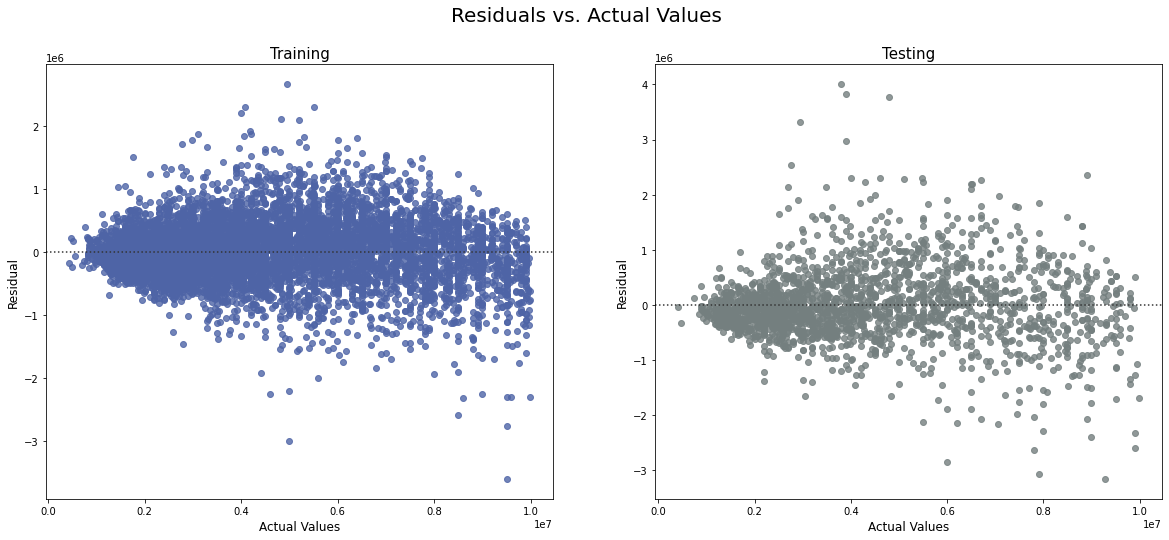

In [69]:
plot_residual(xgbr, X_train, X_test, y_train, y_test)

### XGBoost - Log transformation
---

In [70]:
%%time
xgbr_log = xgboost.XGBRegressor(seed=42)

xgbr_log.fit(X_train, y_train_log)

CPU times: total: 4.08 s
Wall time: 562 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [71]:
reg_metrics(xgbr_log, X_train, X_test, y_train_log, y_test_log, cross_val=False, log_y=True)

-----------Train Data-----------
MAE: 348101.80151119386
MSE: 248359797005.90485
RMSE: 498357.0978785241
R2: 0.9624175632717615
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 456284.2975132146
MSE: 428890647560.50916
RMSE: 654897.4328553359
R2: 0.9340432344190429
--------------------------------


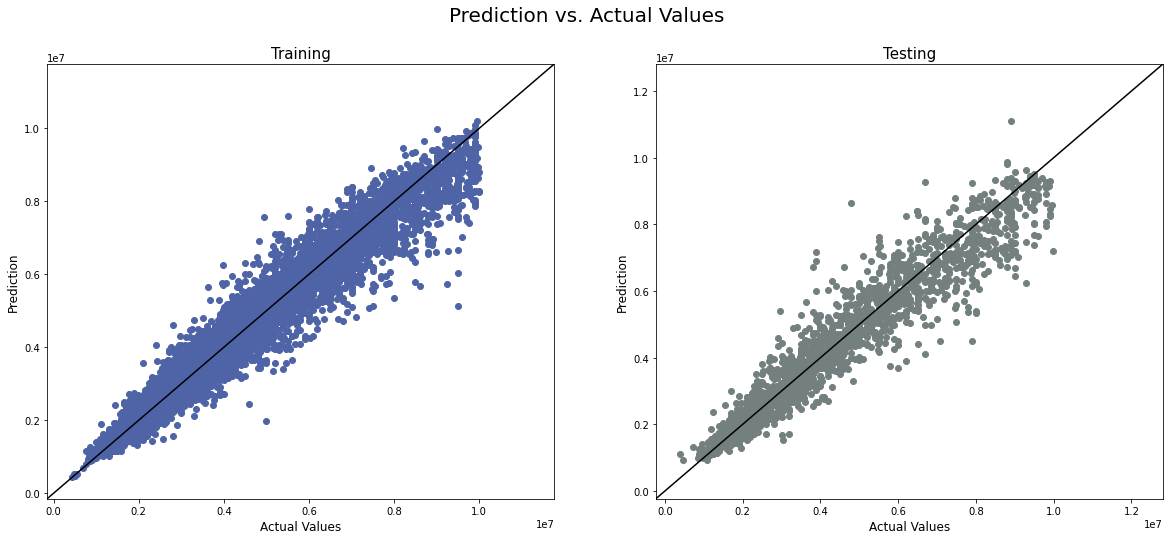

In [72]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(xgbr_log, X_train, X_test, y_train_log, y_test_log, mode='exp')

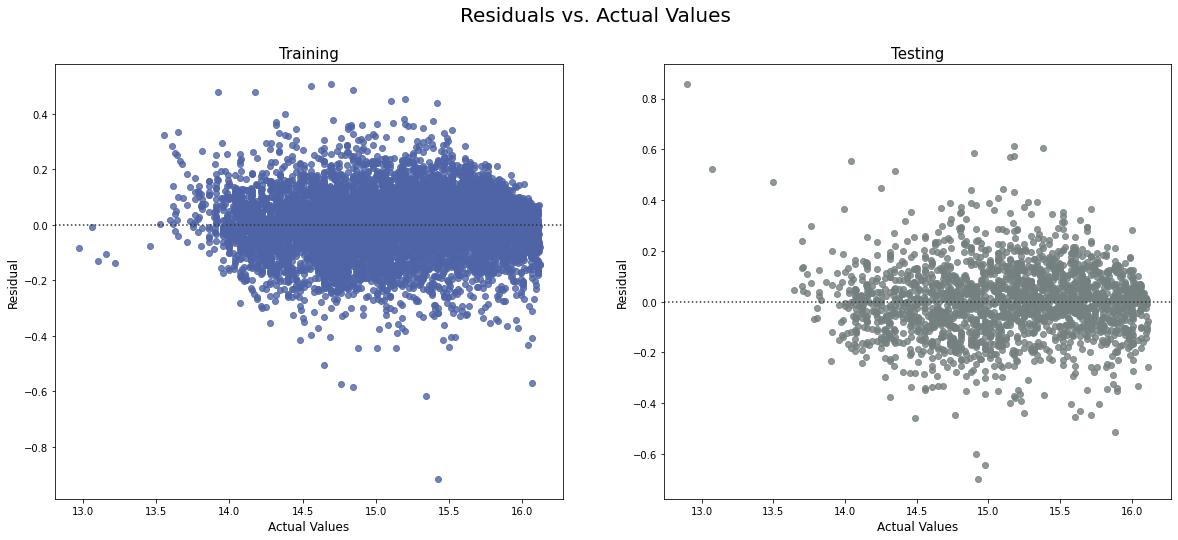

In [86]:
plot_residual(xgbr_log, X_train, X_test, y_train_log, y_test_log)

### XGBoost - Dataset that filling null with median
---
It was cliamed that XGBoost deal with missing values differenct to other models and we're required to fill zero for null values.

In [74]:
%%time
xgbr_median = xgboost.XGBRegressor(seed=42)

xgbr_median.fit(X_train_median, y_train_median)

CPU times: total: 5.67 s
Wall time: 758 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [75]:
reg_metrics(xgbr_median, X_train_median, X_test, y_train_median, y_test, cross_val=False)

-----------Train Data-----------
MAE: 348650.22683990846
MSE: 240299808307.7593
RMSE: 490203.8436280965
R2: 0.9526815230599288
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 469835.2574183085
MSE: 462702462288.50464
RMSE: 680222.3623849077
R2: 0.9123649372198634
--------------------------------


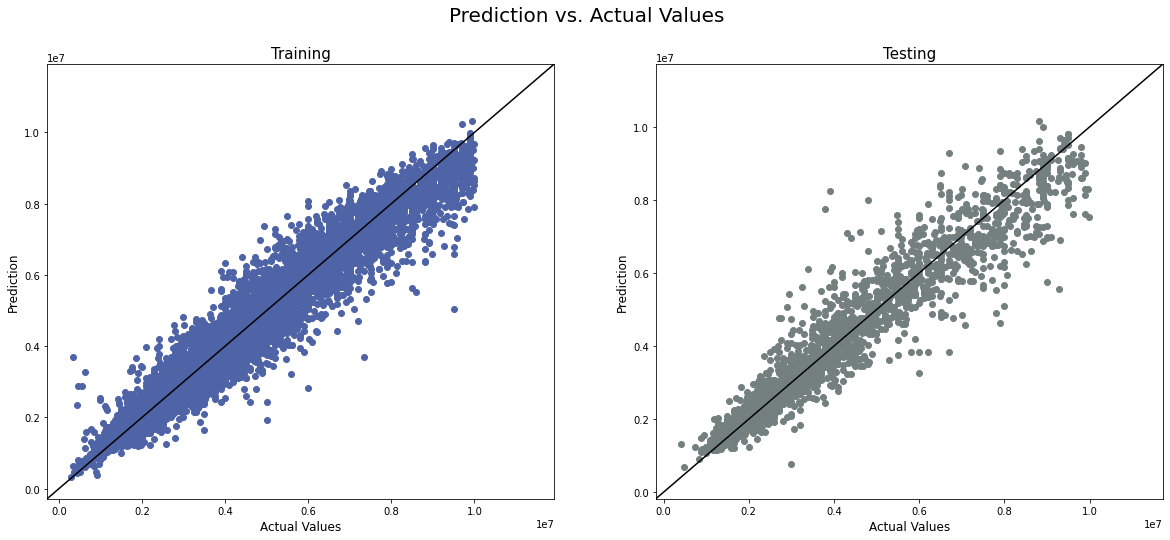

In [76]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(xgbr_median, X_train_median, X_test, y_train_median, y_test)

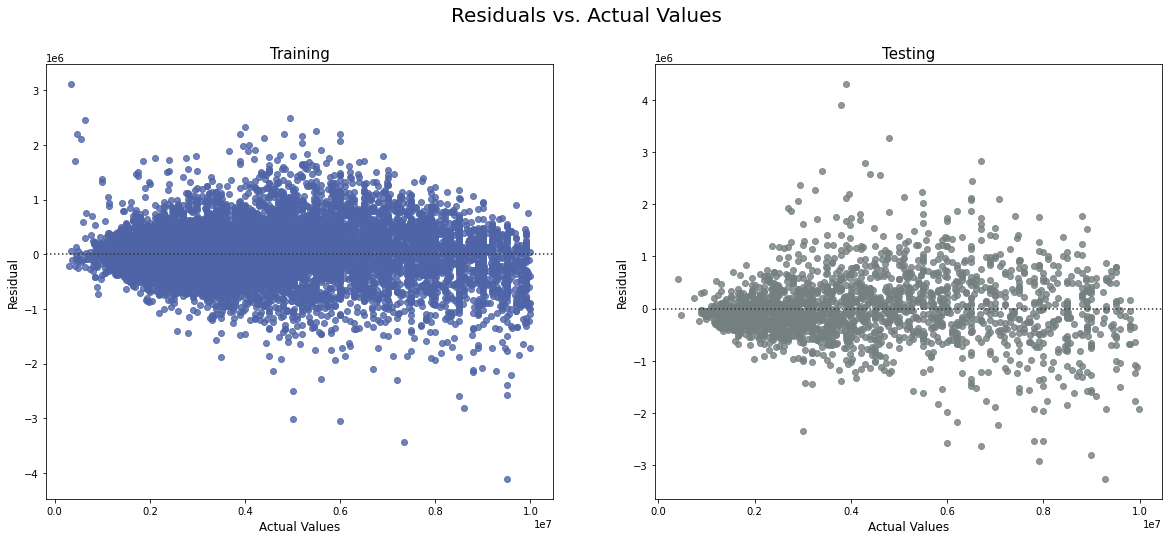

In [77]:
plot_residual(xgbr_median, X_train_median, X_test, y_train_median, y_test)

**Result:** XGBoost without hyperparameters tuning is not performing better than Random Forest.

### XGBoost - Dataset that filling null with zero
---
It was cliamed that XGBoost deal with missing values differenct to other models and we're required to fill zero for null values.

In [78]:
%%time
xgbr_zero = xgboost.XGBRegressor(seed=42)

xgbr_zero.fit(X_train_zero, y_train_zero)

CPU times: total: 5.86 s
Wall time: 759 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [79]:
reg_metrics(xgbr_zero, X_train_zero, X_test, y_train_zero, y_test, cross_val=False)

-----------Train Data-----------
MAE: 335662.8980231264
MSE: 223752243487.74002
RMSE: 473024.569644897
R2: 0.9559399757814041
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 473850.93425636715
MSE: 460964687732.1286
RMSE: 678943.8030736628
R2: 0.9126940687779548
--------------------------------


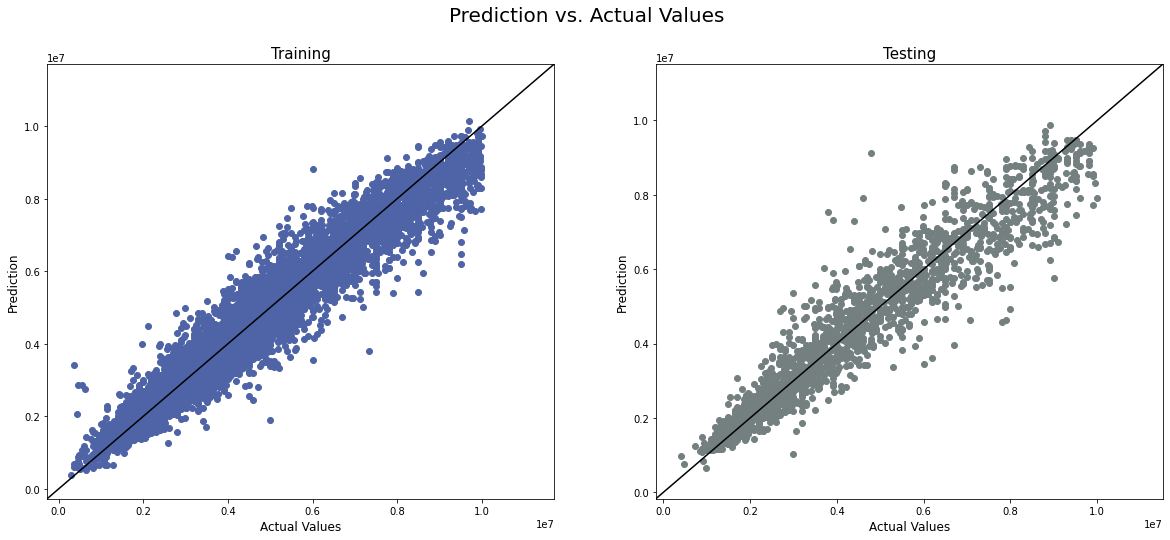

In [80]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(xgbr_zero, X_train_zero, X_test, y_train_zero, y_test)

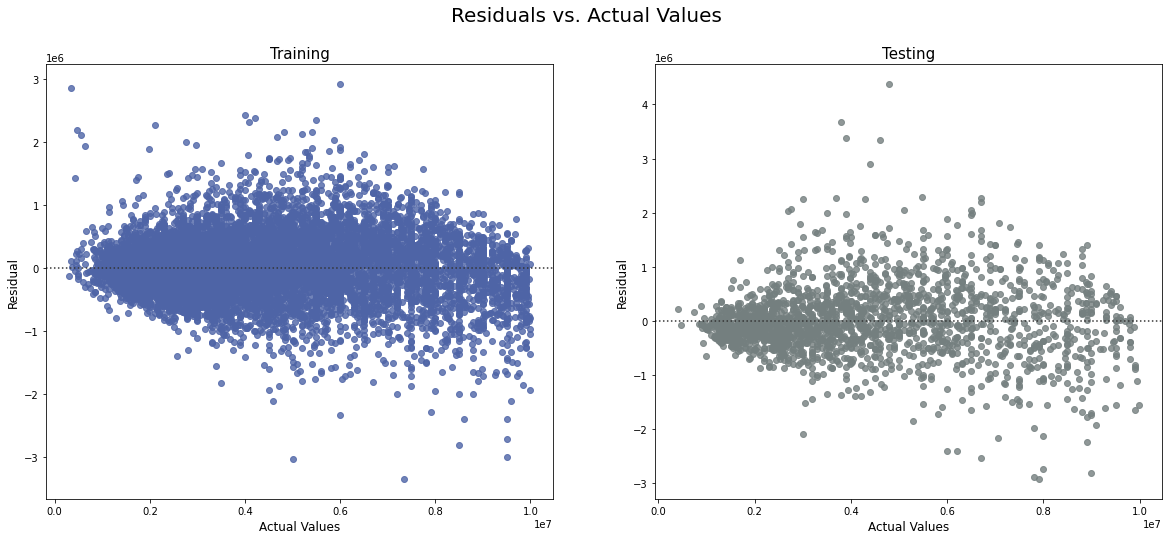

In [81]:
plot_residual(xgbr_zero, X_train_zero, X_test, y_train_zero, y_test)

**Comparing three types of dataset,** models perform similarly. Next step is to use GrideSearch for hyperparameters tuning.

### XGBoost with GridSearch
---

In [149]:
%%time
# Set hyperparametesr
hyper_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_alpha': [0, 1.0, 10.0],
    'reg_lambda': [0, 1.0, 10.0],
    'min_child_weight': [1.5, 6, 10],
    'subsample':[0.6, 0.90]  
}

xgbr_model = xgboost.XGBRegressor(seed=42)

# Instantiate GridSearchCV
xgbr_gridsearch = GridSearchCV(xgbr_model,
                              hyper_params,
                              cv=5,
                              verbose=1,
                              scoring='neg_mean_squared_error'
                              )

# Fit train data
xgbr_gridsearch.fit(X_train, y_train_log);

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
CPU times: total: 4h 30min 26s
Wall time: 35min


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'gamma': [0, 0.25, 1.0], 'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 4, 5],
                         'min_child_weight': [1.5, 6, 10],
                         'reg_alpha': [0, 1.0, 10.0],
                         'reg_lambda': [0, 1.0, 10.0],
                         'subsample': [0.6, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [150]:
xgbr_gridsearch.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1.5,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.6}

In [153]:
reg_metrics(xgbr_gridsearch, X_train, X_test, y_train_log, y_test_log, log_y=True,cross_val=False)

-----------Train Data-----------
MAE: 488970.53072014905
MSE: 477272239045.18756
RMSE: 690848.9263545161
R2: 0.9314694119359999
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 542117.7517719845
MSE: 578453150264.5529
RMSE: 760561.0759594215
R2: 0.9169172821886089
--------------------------------


### Normal XGBoost
---

In [187]:
%%time
xgbr_tune = xgboost.XGBRegressor(gamma=0,
                            learning_rate=0.005,
                            max_depth=5,
                            min_child_weight=10,
                            reg_alpha=1.0, 
                            reg_lambda=15,
                            n_estimators = 3000,
                            colsample_bytree = 0.3,
                            seed=42)

xgbr_tune.fit(X_train, y_train)

reg_metrics(xgbr_tune, X_train, X_test, y_train, y_test, cross_val=False)

-----------Train Data-----------
MAE: 519136.98370149254
MSE: 518672199289.50665
RMSE: 720189.0024774793
R2: 0.9029317491861124
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 558920.1188130706
MSE: 592106465562.6715
RMSE: 769484.5453696075
R2: 0.887856038142811
--------------------------------
CPU times: total: 1min 6s
Wall time: 8.94 s


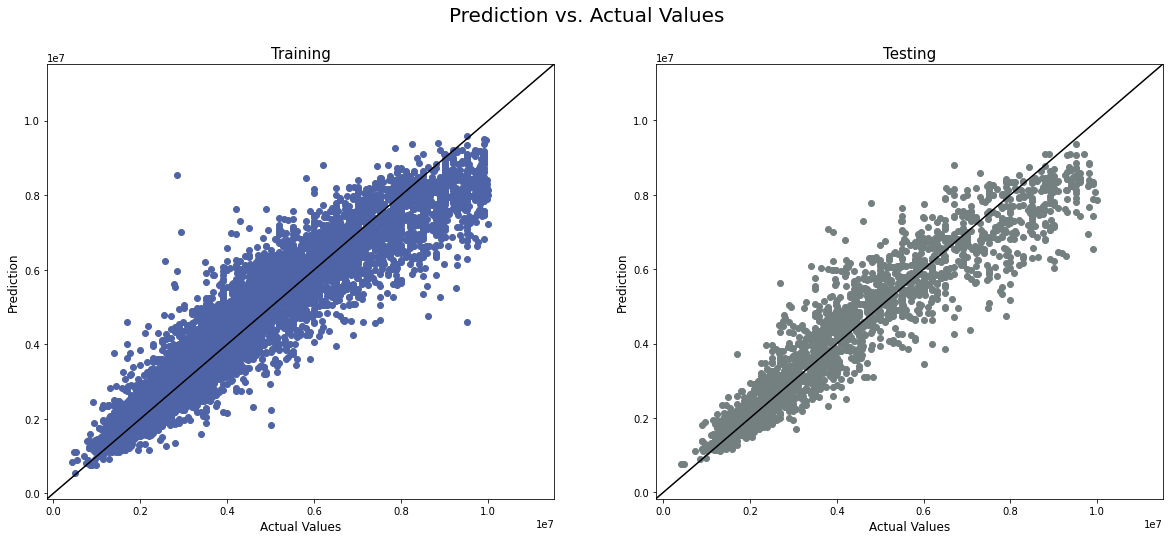

In [189]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(xgbr_tune, X_train, X_test, y_train, y_test)

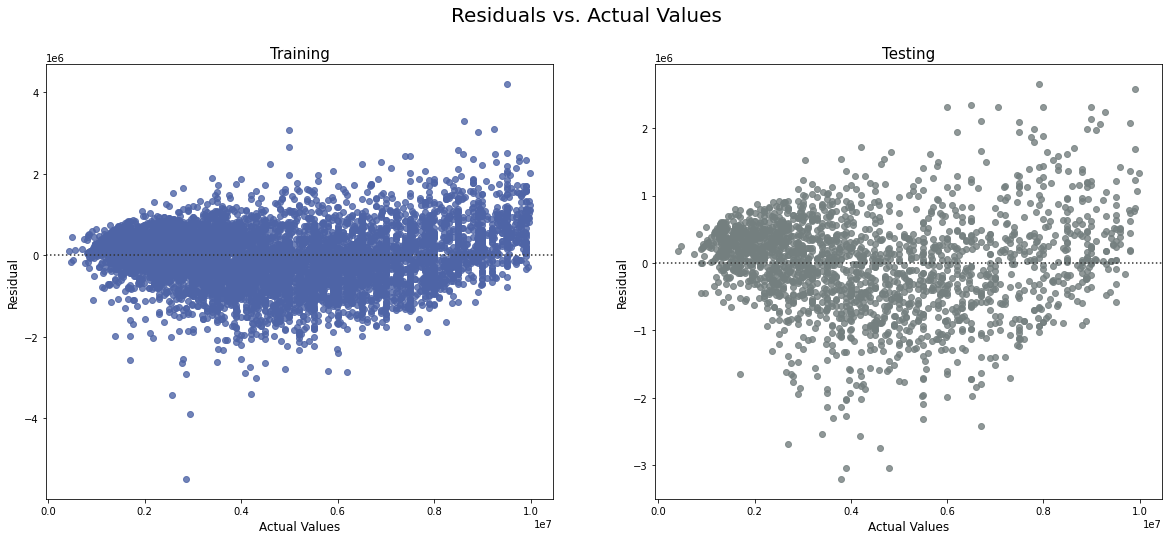

In [190]:
plot_residual(xgbr_tune, X_train, X_test, y_train, y_test)

## 5.3 Neural Networks Model
---
To train NNs model, we need to split our train data to validation dataset.

In [200]:
# Split train and val set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [201]:
# Scale data
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

In [202]:
%%time
# Insert model here...
model = Sequential()

# Hidden layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation=None))

# Compile model (loss fuction optimzing)
model.compile(optimizer='adam',
              loss='mean_squared_error')

res = model.fit(X_train_sc, y_train,
                epochs=500,
                validation_data=(X_val_sc, y_val),
                batch_size = 200,
                verbose=0
         )

CPU times: total: 1min 9s
Wall time: 39.3 s


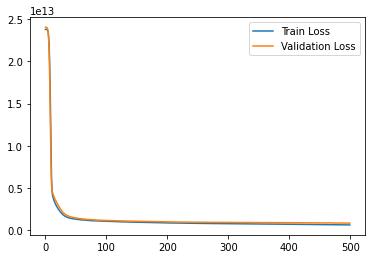

In [203]:
plt.plot(res.history['loss'], label='Train Loss')
plt.plot(res.history['val_loss'], label='Validation Loss')
plt.legend();

In [204]:
# Evaluate
reg_metrics(model, X_train_sc, sc.transform(X_test), y_train, y_test, cross_val=False)

66/66 [==============================] - 0s 982us/step
-----------Train Data-----------
MAE: 542760.5137000327
MSE: 600928400082.499
RMSE: 775195.7172756433
R2: 0.8863444786957541
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 608800.3636472849
MSE: 763802471277.6847
RMSE: 873957.9345012463
R2: 0.8553371054241172
--------------------------------


**Result:** NNs is not suitable for regression problem that is not complex enough, so the model does not perform well.

## 5.4 Final Model
---
**Our best model is Random Forest with median imputation, which can get test set `RMSE:` 678,173**

To understand our model's RMSE, we will test more in different test styles.

In [88]:
# Model
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train_median, y_train_median)

# Evaluate
reg_metrics(final_model, X_train_median, X_test, y_train_median, y_test, cross_val=False)

-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 462566.86907576234
MSE: 459919687818.3884
RMSE: 678173.7888022424
R2: 0.9128919899919309
--------------------------------


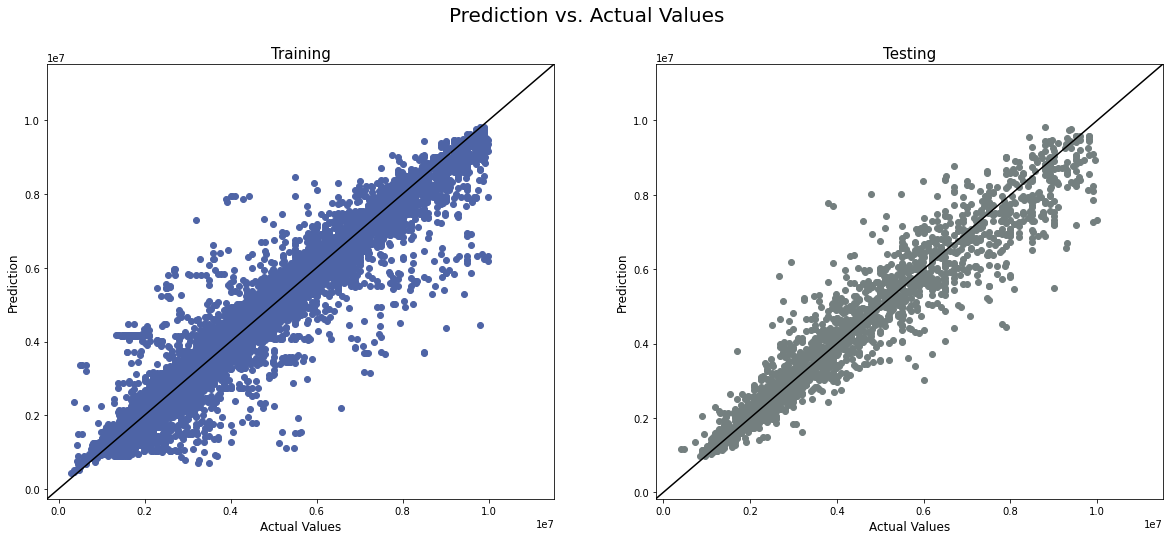

In [89]:
# Plot log actual target vs. log predicted target
plot_ytrue_ypred(final_model, X_train_zero, X_test, y_train_zero, y_test)

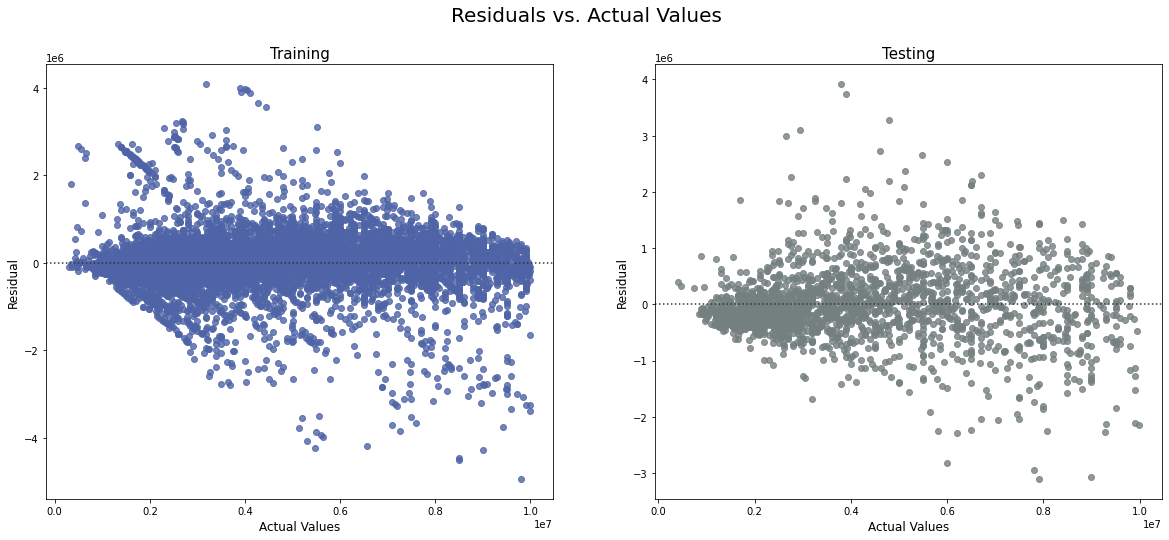

In [90]:
plot_residual(final_model, X_train_zero, X_test, y_train_zero, y_test)

### Prediction by Range of Sale Price
---

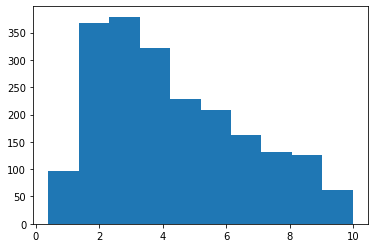

In [285]:
# Check number of bed rooms in test dataset
plt.hist(df_test['sale_price']/1000000);

**We will split and test our model for 2 group of sale price**
1. <= 5 MB
2. \> 5 MB

In [375]:
print('< 5 MB')
y_final_test = y_test[y_test <= 5000000]
X_final_test = X_test.loc[y_final_test.index]

reg_metrics(final_model, X_train_median, X_final_test, y_train_median, y_final_test, cross_val=False)

< 5 MB
-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 352282.95811183634
MSE: 288071891426.4827
RMSE: 536723.2913024017
R2: 0.7581744636702857
--------------------------------


In [354]:
print('> 5 MB')
y_final_test = y_test[y_test > 5000000]
X_final_test = X_test.loc[y_final_test.index]

reg_metrics(final_model, X_train_median, X_final_test, y_train_median, y_final_test, cross_val=False)

> 5 MB
-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 672814.8278268223
MSE: 787534551051.5605
RMSE: 887431.4345635726
R2: 0.5724450688917615
--------------------------------


### Prediction by Number of Bedroom
---

In [278]:
X_test['bedrooms'].value_counts()

1.00    1607
2.00     457
3.00      14
4.00       2
0.00       1
Name: bedrooms, dtype: int64

In [355]:
print('1 Bedroom')
X_final_test = X_test[X_test['bedrooms'] == 1]
y_final_test = y_test.loc[X_final_test.index]


reg_metrics(final_model, X_train_median, X_final_test, y_train_median, y_final_test, cross_val=False)

1 Bedroom
-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 407214.7372825827
MSE: 357614795099.2937
RMSE: 598009.0259346373
R2: 0.9194443194865813
--------------------------------


In [356]:
print('2 Bedrooms')
X_final_test = X_test[X_test['bedrooms'] == 2]
y_final_test = y_test.loc[X_final_test.index]


reg_metrics(final_model, X_train_median, X_final_test, y_train_median, y_final_test, cross_val=False)

2 Bedrooms
-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 642343.2364629125
MSE: 795283980603.3608
RMSE: 891786.9592023427
R2: 0.8174004980526152
--------------------------------


In [357]:
print('> 2 Bedrooms')
X_final_test = X_test[X_test['bedrooms'] > 2]
y_final_test = y_test.loc[X_final_test.index]


reg_metrics(final_model, X_train_median, X_final_test, y_train_median, y_final_test, cross_val=False)

> 2 Bedrooms
-----------Train Data-----------
MAE: 236893.1030211803
MSE: 123847045106.56094
RMSE: 351919.08886356384
R2: 0.9756127414780733
Cross Validation: None
Cross Validation Mean: None
--------------------------------
-----------Test Data-----------
MAE: 879294.7606250001
MSE: 1163460975359.571
RMSE: 1078638.4822356242
R2: 0.43590785830169687
--------------------------------


### Prediction by Other website prediction

In [358]:
# https://www.ddproperty.com/en/property/59-heritage-sukhumvit-59-bangkok-for-sale-10392967

test_data = {
    'district' : ['Watthana'],
    'bedrooms' : [1], 
    'bathrooms' : [1], 
    'internal_area' : [55],
    'floors' : [19], 
    'towers' : [1], 
    'year_built' : [2009], 
    'has_elevator' : [1], 
    'has_parking' : [1],
    'has_security' : [1], 
    'has_cctv' : [1], 
    'has_pool' : [1], 
    'has_sauna' : [0], 
    'has_gym' : [1],
    'has_garden_bbq' : [0], 
    'has_playground' : [0], 
    'has_shop_on_premise' : [0],
    'has_restaurant_on_premise' : [0], 
    'has_wifi' : [0], 
    'city_train_distance' : [780],
    'express_way_distance' : [2800], 
    'close_city_train' : [1], 
    'close_express_way' : [0]
}

make_prediction(final_model, test_data)

Expected value is: 6091393.7514285715 THB


In [387]:
# https://www.ddproperty.com/en/property/ideo-o2-%E0%B8%9A%E0%B8%B2%E0%B8%87%E0%B8%99%E0%B8%B2-bangkok-for-sale-9856231
test_data = {
    'district' : ['Bang Na'],
    'bedrooms' : [1], 
    'bathrooms' : [1], 
    'internal_area' : [27],
    'floors' : [11], 
    'towers' : [1], 
    'year_built' : [2017], 
    'has_elevator' : [1], 
    'has_parking' : [1],
    'has_security' : [1], 
    'has_cctv' : [1], 
    'has_pool' : [1], 
    'has_sauna' : [0], 
    'has_gym' : [1],
    'has_garden_bbq' : [0], 
    'has_playground' : [0], 
    'has_shop_on_premise' : [0],
    'has_restaurant_on_premise' : [0], 
    'has_wifi' : [0], 
    'city_train_distance' : [570],
    'express_way_distance' : [2000], 
    'close_city_train' : [1], 
    'close_express_way' : [0]
}

make_prediction(final_model, test_data)

Expected value is: 2586482.848666667 THB


In [389]:
# https://www.ddproperty.com/en/property/%E0%B8%84%E0%B8%AD%E0%B8%99%E0%B9%82%E0%B8%94-the-coast-bangkok-%E0%B9%80%E0%B8%94%E0%B8%AD%E0%B8%B0-%E0%B9%82%E0%B8%84%E0%B8%AA%E0%B8%95%E0%B9%8C-%E0%B9%81%E0%B8%9A%E0%B8%87%E0%B8%84%E0%B9%87%E0%B8%AD%E0%B8%81-bangkok-for-sale-8906630
test_data = {
    'district' : ['Bang Na'],
    'bedrooms' : [2], 
    'bathrooms' : [2], 
    'internal_area' : [57.6],
    'floors' : [21], 
    'towers' : [1], 
    'year_built' : [2012], 
    'has_elevator' : [1], 
    'has_parking' : [1],
    'has_security' : [1], 
    'has_cctv' : [1], 
    'has_pool' : [1], 
    'has_sauna' : [1], 
    'has_gym' : [1],
    'has_garden_bbq' : [1], 
    'has_playground' : [1], 
    'has_shop_on_premise' : [1],
    'has_restaurant_on_premise' : [1], 
    'has_wifi' : [0], 
    'city_train_distance' : [850],
    'express_way_distance' : [500], 
    'close_city_train' : [1], 
    'close_express_way' : [1]
}

make_prediction(final_model, test_data)

Expected value is: 6978676.703333332 THB


# 6. Summarization
---


1. The final model is Random Forest with missing values replacement by its median.
2. Model perform better on lower price (< 5 MB) condominiums.
3. Currently, model performance base on data.
    - If we have a large and up to date dataset, model tends to perform well.
4. Outlier is one of the important factor to concern working with price prediction.


# 7. Future Works
---

1. Explore more about feature engineering.

2. This project's model and dataset do not captured element of design which is one of main factor that could make impact on condominium value. So the next project would capture it by using condominium images to predict condominium price as well.

3. Conduct analysis do select worth investment condominium.

# 8. For presentation
---

In [299]:
# Read saved csv file
df_present = pd.read_csv('./data/condominium_price_all_clean_final.csv')

In [301]:
df_present.drop_duplicates(inplace=True)

In [302]:
df_present.shape

(19986, 30)

`sale_price` before dropping data

---

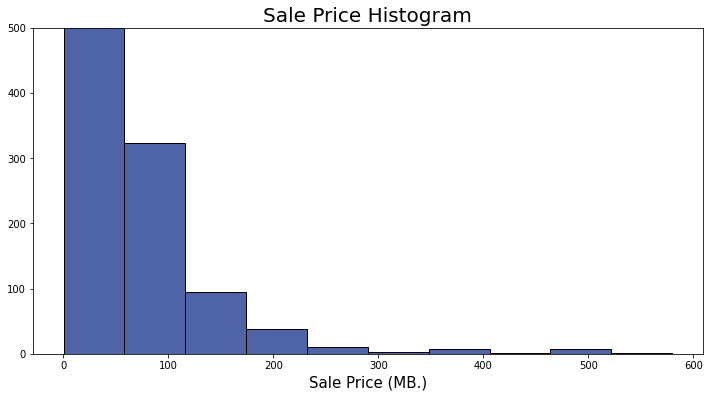

In [360]:
plt.figure(figsize=(12, 6))
plt.hist(df_present['sale_price']/1000000, color='#4E64A6', edgecolor='black')
plt.ylim(0,500)
plt.xlabel('Sale Price (MB.)', size=15)
plt.title('Sale Price Histogram', size=20);

In [341]:
print(f"Skewness: {df_present['sale_price'].skew()}")
print(f"Max: {df_present['sale_price'].max()}")
print(f"Min: {df_present['sale_price'].min()}")
print(f"Mean: {df_present['sale_price'].mean()}")
print(f"Median: {df_present['sale_price'].median()}")

Skewness: 9.660362976053605
Max: 580000000.0
Min: 300000.0
Mean: 10341023.95955619
Median: 4500000.0


`sale_price` after dropping data

---

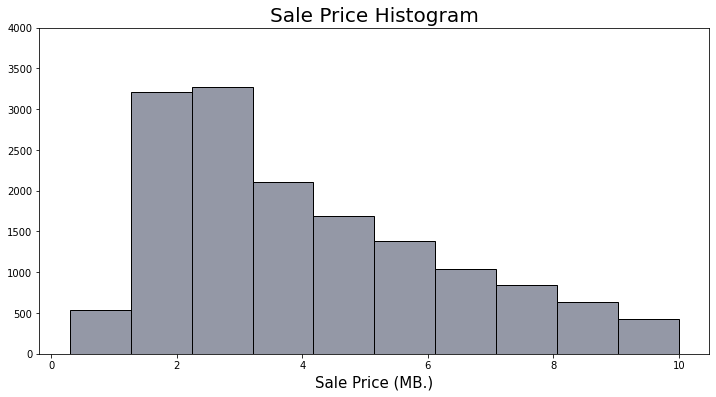

In [362]:
plt.figure(figsize=(12, 6))
plt.hist(df['sale_price']/1000000, color='#9498A6', edgecolor='black')
plt.ylim(0,4000)
plt.xlabel('Sale Price (MB.)', size=15)
plt.title('Sale Price Histogram', size=20);

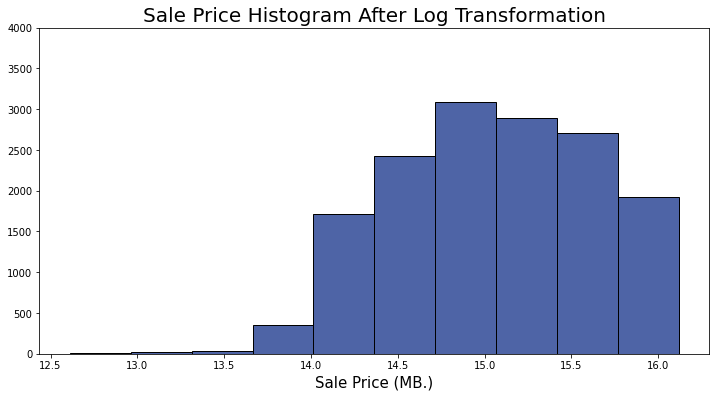

In [368]:
plt.figure(figsize=(12, 6))
plt.hist(np.log(df['sale_price']), color='#4E64A6', edgecolor='black')
plt.ylim(0,4000)
plt.xlabel('Sale Price (MB.)', size=15)
plt.title('Sale Price Histogram After Log Transformation', size=20);

In [366]:
print(f"Skewness: {np.log(df['sale_price']).skew()}")

Skewness: -0.16011870444253543


In [349]:
print(f"Skewness: {df['sale_price'].skew()}")
print(f"Max: {df['sale_price'].max()}")
print(f"Min: {df['sale_price'].min()}")
print(f"Mean: {df['sale_price'].mean()}")
print(f"Median: {df['sale_price'].median()}")

Skewness: 0.7666460517851982
Max: 9995000.0
Min: 300000.0
Mean: 4036989.055513125
Median: 3450000.0


Skewness: 9.660362976053605


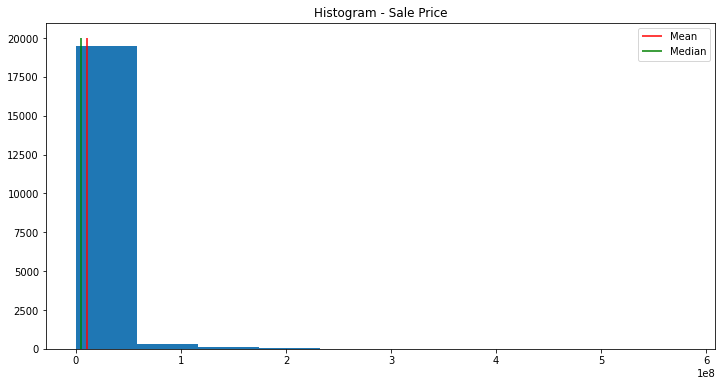

In [90]:
# Plot sale_price distribution.

print('Skewness:', df['sale_price'].skew())

plt.figure(figsize=(12, 6))
plt.hist(df['sale_price'])
plt.vlines(df['sale_price'].mean(), ymin=0, ymax=df.shape[0], color='red', label='Mean')
plt.vlines(df['sale_price'].median(), ymin=0, ymax=df.shape[0], color='Green', label='Median')
plt.title('Histogram - Sale Price')
plt.legend();


## The saleprice distribution is right skew so we could normalize it by using log e

---